# Imports

In [ ]:
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import files
import io
import random
import math
from re import S
from datetime import datetime
from google.colab import files
from heapq import heappush, heappop
from collections import defaultdict
from openpyxl import load_workbook
import os
from scipy import stats
from IPython.display import display, HTML
from collections import defaultdict
import warnings
from scipy.stats import t

# התאמת התפלגויות

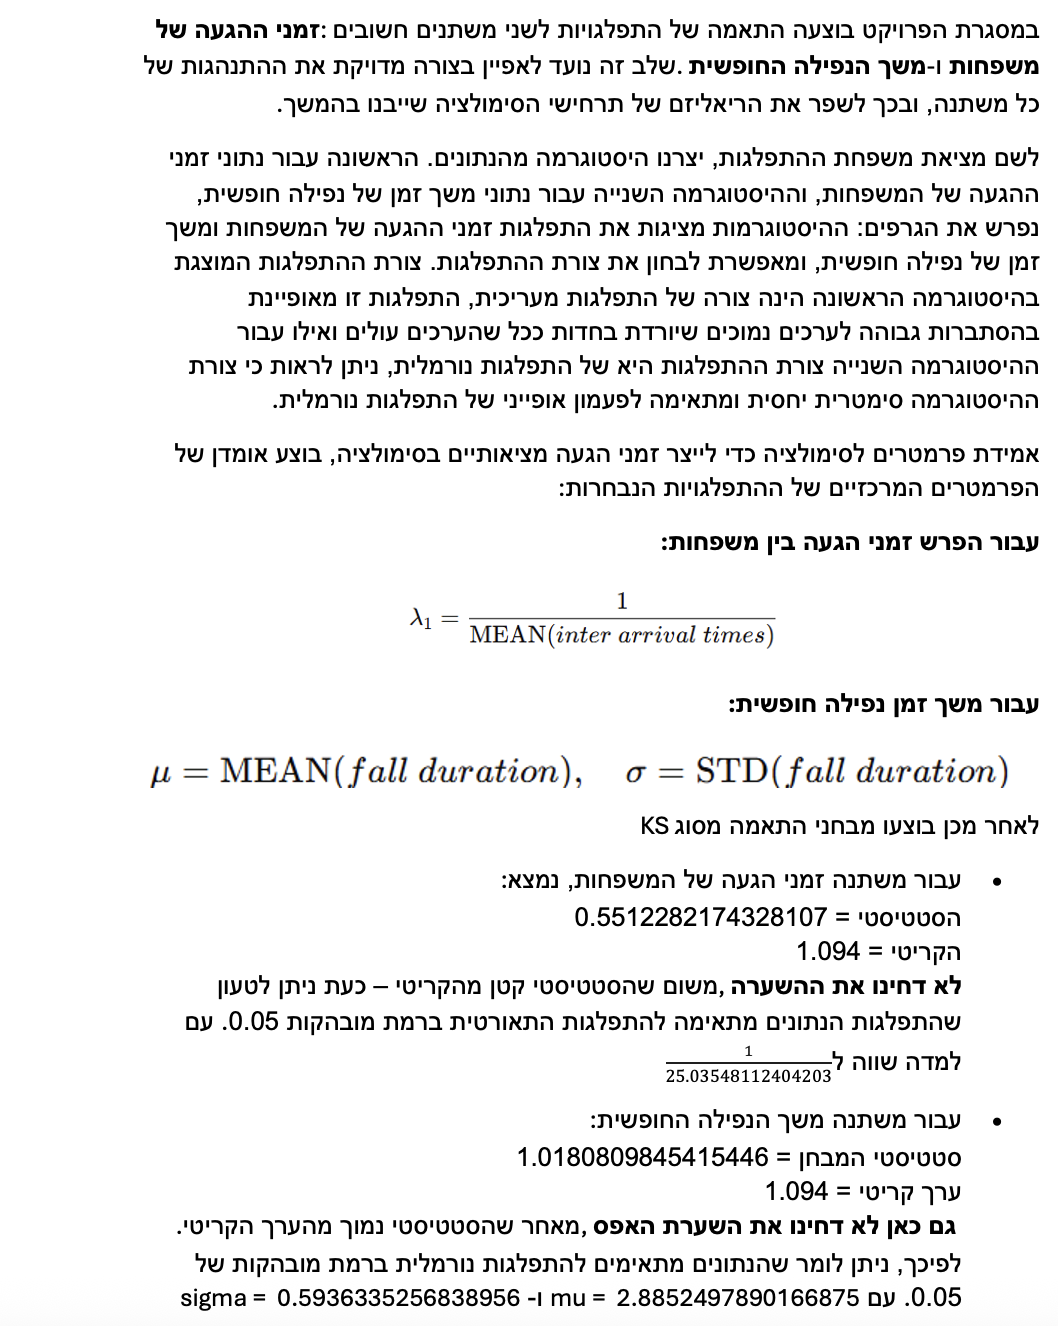

Saving זמנים פרויקט.xlsx to זמנים פרויקט (1).xlsx


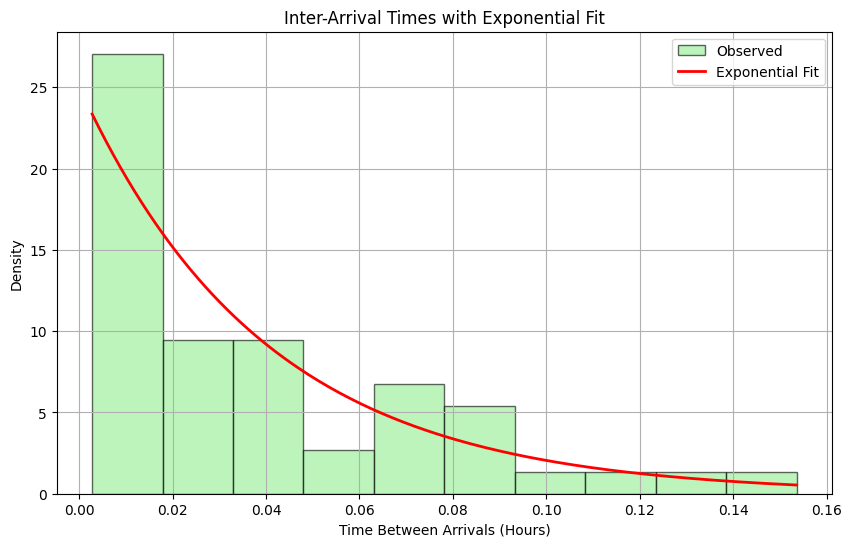

KS Statistic (from scratch): 0.5512282174328107
Fail to reject the null hypothesis (H0). The inter-arrival times follow an exponential distribution.
lambda_mle: 25.03548112404203


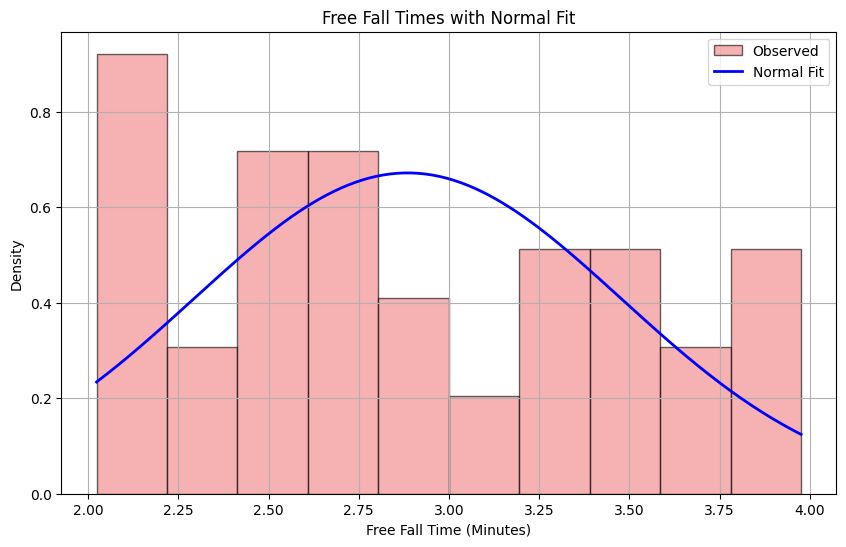

mu =  2.8852497890166875
sigma =  0.5936335256838956

KS Statistic for free fall time (Normal fit, from scratch): 1.0180809845415446
Fail to reject the null hypothesis (H0). The free fall times follow a normal distribution.


In [ ]:
# Upload and load Excel
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_excel(io.BytesIO(uploaded[file_name]))

#========== family arrival hours ==========
# Convert arrival times to datetime and then to decimal hours
df['שעות הגעה משפחות'] = pd.to_datetime(df['שעות הגעה משפחות'], format="%H:%M:%S")
df['arrival_hours'] = (
    df['שעות הגעה משפחות'].dt.hour +
    df['שעות הגעה משפחות'].dt.minute / 60 +
    df['שעות הגעה משפחות'].dt.second / 3600
)

# Compute inter-arrival times
sorted_arrivals = np.sort(df['arrival_hours'].to_numpy())
inter_arrival_times = np.diff(sorted_arrivals)

# === Estimate lambda using MLE ===
lambda_mle = 1 / np.mean(inter_arrival_times)

# Plot histogram with exponential PDF overlay
x_vals = np.linspace(inter_arrival_times.min(), inter_arrival_times.max(), 200)
exp_pdf = stats.expon.pdf(x_vals, scale=1 / lambda_mle)

plt.figure(figsize=(10, 6))
plt.hist(inter_arrival_times, bins=10, density=True, alpha=0.6, color='lightgreen', edgecolor='black', label='Observed')
plt.plot(x_vals, exp_pdf, 'r-', lw=2, label='Exponential Fit')
plt.title('Inter-Arrival Times with Exponential Fit')
plt.xlabel('Time Between Arrivals (Hours)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# === Define empirical CDF ===
def empirical_cdf(data):
    data_sorted = np.sort(data)
    n = len(data)
    return data_sorted, np.arange(1, n + 1) / n

# === Define theoretical CDF for exponential ===
def exp_cdf(x, lam):
    return 1 - np.exp(-lam * x)

# === Perform K-S test manually ===
def ks_test(data, cdf, *params):
    data_sorted, ecdf = empirical_cdf(data)
    tcdf = cdf(data_sorted, *params)
    d_max = np.max(np.abs(ecdf - tcdf))
    return d_max

# === K-S Test for inter-arrival times ===
d_max = ks_test(inter_arrival_times, exp_cdf, lambda_mle)
n = len(inter_arrival_times)
d_statistic = (d_max - 0.2 / n) * (n ** 0.5 + 0.26 + 0.5 / (n ** 0.5))
critical_value = 1.094

print(f"KS Statistic (from scratch): {d_statistic}")
if critical_value > d_statistic:
    print("Fail to reject the null hypothesis (H0). The inter-arrival times follow an exponential distribution.")
    print(f"lambda_mle: {lambda_mle}")
else:
    print("Reject the null hypothesis (H0). The inter-arrival times do not follow an exponential distribution.")

# ========== free fall times ==========

# Extract free fall times column
free_fall_times = df['זמן נפילה חופשית'].to_numpy()

# Estimate parameters for normal distribution
mu_ff = np.mean(free_fall_times)
sigma_ff = np.std(free_fall_times)

# Plot histogram with normal PDF overlay
x_vals_ff = np.linspace(free_fall_times.min(), free_fall_times.max(), 200)
normal_pdf_ff = stats.norm.pdf(x_vals_ff, loc=mu_ff, scale=sigma_ff)

plt.figure(figsize=(10, 6))
plt.hist(free_fall_times, bins=10, density=True, alpha=0.6, color='lightcoral', edgecolor='black', label='Observed')
plt.plot(x_vals_ff, normal_pdf_ff, 'b-', lw=2, label='Normal Fit')
plt.title('Free Fall Times with Normal Fit')
plt.xlabel('Free Fall Time (Minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

# Define normal CDF
def norm_cdf(x, mu, sigma):
    return stats.norm.cdf(x, loc=mu, scale=sigma)

# K-S Test for free fall times
d_max_ff = ks_test(free_fall_times, norm_cdf, mu_ff, sigma_ff)
n_ff = len(free_fall_times)
d_statistic_ff = (d_max_ff - 0.2 / n_ff) * (n_ff ** 0.5 + 0.26 + 0.5 / (n_ff ** 0.5))

print("mu = ", mu_ff)
print("sigma = ", sigma_ff)
print(f"\nKS Statistic for free fall time (Normal fit, from scratch): {d_statistic_ff}")
if critical_value > d_statistic_ff:
    print("Fail to reject the null hypothesis (H0). The free fall times follow a normal distribution.")
else:
    print("Reject the null hypothesis (H0). The free fall times do not follow a normal distribution.")



# Sampling Algorithms

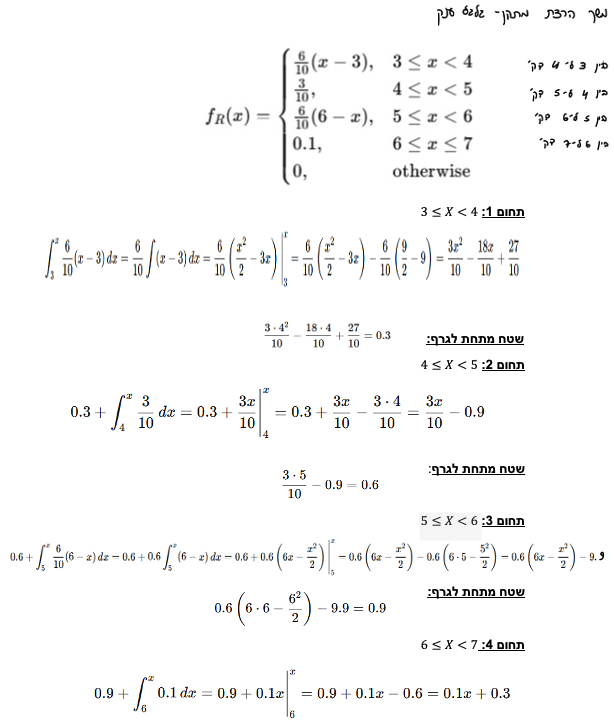

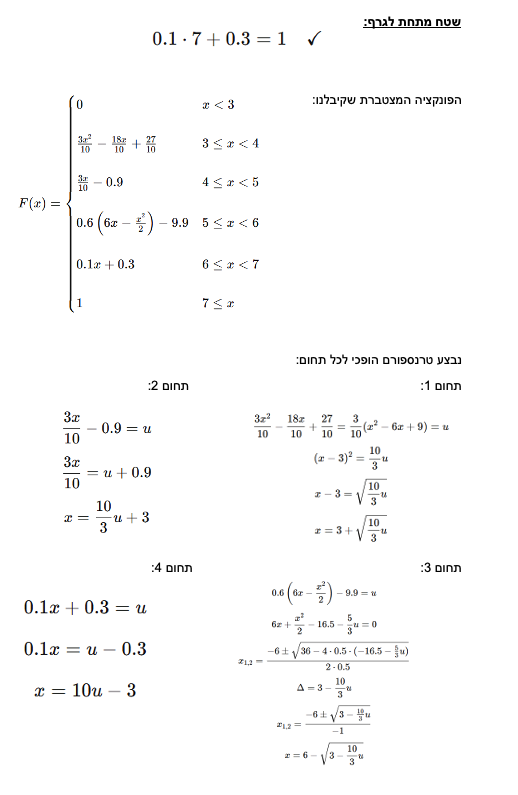

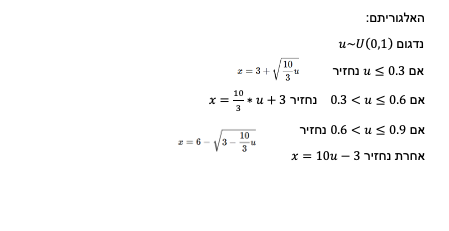

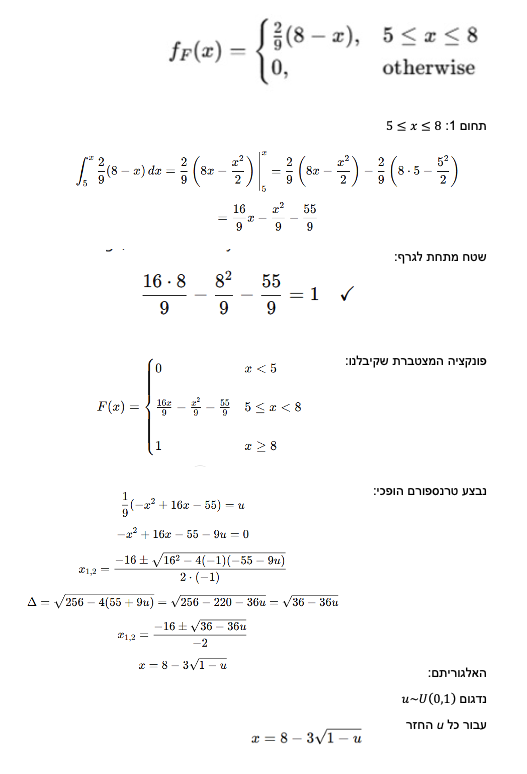

In [ ]:

class SimulationUtils:
    def sample_amount_kids(self):
        u = random.random()
        if u < 1/3:
            return 1
        elif u < 2/3:
            return 2
        else:
            return 3

    def sample_amount_teenagers(self):
        u = random.random()
        if u < 1/4:
            return 3
        elif u < 2/4:
            return 4
        elif u < 3/4:
            return 4
        else:
            return 6

    def sample_exponential(self, lmbda):
      u = random.uniform(0, 1)
      return -math.log(1 - u) / lmbda

    def sample_triangular(self, a, c, b):
      return random.triangular(a, c, b)

    def sample_uniform(self,a, b):
         return random.uniform(a, b)

    def sample_family_arrival(self):
        return self.sample_exponential(1/25.03548112404203)

    def sample_teenagers_arrival(self):
        return self.sample_exponential(0.5)

    def sample_couple_arrival(self):
        return self.sample_exponential(0.333333)

    def sample_single_arrival(self):
        return self.sample_exponential(0.25)

    def sample_normal(self, mu, sigma):
        u1 = random.random()
        u2 = random.random()
        z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
        return mu + sigma * z

    def sample_ticket_service_time(self, alternative):
        if alternative==0:
          return self.sample_normal(mu=3, sigma=1)
        elif alternative == 1 or alternative == 2:
          return self.sample_normal(mu=1.5, sigma=0.5)


    def sample_big_rollercoaster_ride_time(self):
        return self.sample_normal(mu=3, sigma=1)

    def sample_small_rollercoaster_ride_time(self):
        return 2


    def sample_ferris_wheel_ride_time(self):
        u = random.random()
        if u < 0.3:
            return 3 + math.sqrt(10*u / 3)

        elif u < 0.6:
            return 3 + 10*u/ 3

        elif u < 0.9:
            return 6 - math.sqrt(3-10*u/3)

        else:
            return 10*u-3

    def sample_free_fall_ride_time(self):
        return self.sample_normal(mu=2.8, sigma=0.6)

    def sample_tubing_river_ride_time(self):
        u = random.random()
        return 8 - 3* math.sqrt(1 - u)

    def sample_bumper_cars_ride_time(self):
        return random.uniform(3, 5)

    def sample_boat_capsizes_ride_time(self):
        return 4


    def sample_chinese_food_service_time(self):
        return self.sample_uniform(3, 5)


    def sample_falafel_service_time(self):
        return self.sample_uniform(2, 3)

    def sample_hotdog_service_time(self):
        return self.sample_triangular(3, 5, 4)

    def sample_eating_duration(self):
        return self.sample_uniform(20, 40)

    def sample_eating_policy(self):
        u = random.random()
        if u < 0.5:
            return 0
        elif u < 0.75:
            return 2
        else:
            return 3

    def sample_restaurant_choice(self):
        u = random.random()
        if u < 4/9:
            return 'hotdog'
        elif u < 8/9:
            return 'falafel'
        else:
            return 'chinese'

# Objects

<div dir="rtl">

## הסבר על האובייקטים בקוד:
**Visitor:** מייצג את המבקרים שמגיעים לפארק. לכל מבקר יש שדה שמייצג את סוג המבקר: (משפחה, בני נוער, זוגות או יחידים). במידה ומדובר במבקר שהוא קבוצה, כמו למשל קבוצת בני נוער או משפחה, יש גם גודל קבוצה הנקבע על פי סוג המבקר. מחלקת visitor כוללת עוד שדות כגון: מתקנים שהוא יכול לעשות, מתקנים שננטשו אם מדובר בסוג מבקר שיכול לנטוש, שדה המייצג האם המבקר רעב, מסעדה נבחרת, וקאונטר שסופר את כמות המתקנים שמבקר כבר ביצע.

**Ride:** מייצג מתקן בפארק השעשועים. למתקן שם, קיבולת, סוג מתקן ("משפחתי"/"אקסטרים"), תור פעיל של קבוצות מבקרים, ורשימת מבקרים שמבצעים כעת סיבוב על המתקן. בנוסף, לכל מתקן יש פונקציית דגימה מותאמת הקובעת את משך הפעילות בהתאם לסוג המתקן.

**FoodStall:** מייצג דוכן אוכל בפארק. וכולל שדה המייצג את סוג הדוכן: פלאפל, נקניקיות ואוכל סיני. לדוכן אוכל יש גם רשימה המייצגת את הלקוחות הנוכחיים שלה, ובנוסף גם פונקציית דגימת זמן שירות בהתאם לסוג הדוכן.

**RideManager:** מייצג מעין מחלקת עזר המנהלת את כלל המתקנים בפארק. כולל בין היתר השמה של תוכנית מתקנים מתאימה עבור סוגי המבקרים השונים בפארקת או בחירת המתקן עם התור הקצר ביותר עבור מבקרים שבוחרים כך את המתקן הבא עליו יעלו.

**Event:** מחלקת אירוע בסיסית אותה כלל האירועים שתכנתנו יורשים, והיא כוללת פונקציית התמודדות עם אירוע על מנת שכלל האירועים שיורשים אותה יכללו אחת כזאת, בהתאם לכל מה שקורה באירוע.


---

### משאבים
כפי שנכתב בהנחיות, המשאבים בפארק הם 2 עמדות כרטיסים בכניסה לפארק, 7 מתקנים מסוגים שונים, 3 עמדות אוכל שונות (נקניקיות, פלאפל ואוכל סיני).
כלל המופעים של האובייקטים נוצרים בתחילת הסימולציה


---

### הנחות:



*   
יחידת זמן הסימולציה שנקבעה היא דקה (1 יחידת זמן = 1 דקה). זמני פעילות הפארק הם החל מהדקה ה־ 600 (10:00) עד הדקה ה־1320 (22:00).
*   כל סוג מבקר ראשון מגיע בתחילת חלון הזמן בו הוא יכול להגיע, בתוספת מספר דקות אותן דוגמים מפונקצייה המייצגת את אלגוריתם הדגימה עבור הגעה של סוג המבקר הספציפי.



Visitor: represents the visitors in the park.


In [ ]:
class Visitor:
    def __init__(self, visitor_type, arrival_time, simulation_utils, ride_plan):
        self.id = None
        self.visitor_type = visitor_type
        self.sim = simulation_utils

        self.group_size = self.assign_group_size()
        self.arrival_time = self.assign_arrival_time()

        self.hungry = True
        self.rides_completed = 0
        self.status= "not enter"
        # Eating behavior and restaurant choice
        self.eating_policy = self.sim.sample_eating_policy()
        self.restaurant_choice = None if self.eating_policy == 0 else self.sim.sample_restaurant_choice()
        if self.eating_policy==0:
            self.hungry= False
        self.ride_plan = ride_plan

        # Max wait time for a ride (in minutes)
        self.max_wait_time = self.assign_max_wait_time()

        # Track abandoned rides – teenagers and couple
        if self.visitor_type == 'teenagers':
            self.abandoned_once = set()
            self.last_abandoned_ride = None

        if self.visitor_type == 'couple':
           self.ride_abandoned = set()
           self.finished_extreme = False

    def assign_group_size(self):
        if self.visitor_type == 'family':
            return 2 + self.sim.sample_amount_kids()
        elif self.visitor_type == 'teenagers':
            return self.sim.sample_amount_teenagers()
        elif self.visitor_type == 'couple':
            return 2
        elif self.visitor_type == 'single':
            return 1
        else:
            raise ValueError("Unknown visitor type")

    def assign_arrival_time(self):
        if self.visitor_type == 'family':
            return self.sim.sample_family_arrival()
        elif self.visitor_type == 'teenagers':
            return self.sim.sample_teenagers_arrival()
        elif self.visitor_type == 'couple':
            return self.sim.sample_couple_arrival()
        elif self.visitor_type == 'single':
            return self.sim.sample_single_arrival()
        else:
            return None

    def assign_max_wait_time(self):
        if self.visitor_type == 'teenagers':
            return 15  # minutes
        elif self.visitor_type == 'couple':
            return 20
        elif self.visitor_type == 'single':
            return None  # chooses by shortest queue
        elif self.visitor_type == 'family':
            return None  # assumed to wait as group
        else:
            return None

    def __str__(self):
        return (f"{self.visitor_type.title()} (Group size: {self.group_size}, "
                f"Arrival: {self.arrival_time:.2f}, "
                f"Eating: {'No' if self.eating_policy == 0 else f'After {self.eating_policy} rides'}, "
                f"Restaurant: {self.restaurant_choice or 'N/A'}, "
                f"Max wait: {self.max_wait_time if self.max_wait_time else 'N/A'})")


Ride: represents the rides in the Luna Park

In [ ]:
class Ride:
    def __init__(self, name, capacity, ride_type, duration_func):
        self.name = name
        self.capacity = capacity
        self.ride_type = ride_type
        self.duration_func = duration_func

        self.queue = []
        self.current_riders = []
        self.waiting_times = []
        self.is_busy = False
        self.time_remaining = 0

        # statistics
        self.total_rounds_riders = 0
        self.total_waiting_for_rides_time = 0
        self.total_Visitors_riders = 0
        self.amount_of_times_abandoned = 0
        self.total_groups_riders= 0
        self.queue_length_log= []

    def add_to_queue(self, visitor):
        visitor.entering_queue = visitor.entering_queue if hasattr(visitor, 'entering_queue') else 0
        self.queue.append(visitor)

    def sample_duration(self):
        return self.duration_func()


    def get_queue_length(self):
        return len(self.queue)

    def __str__(self):
        return f"Ride({self.name}, type={self.ride_type}, queue={len(self.queue)})"


Food Stall: represents the food stalls in the park.

In [ ]:
class FoodStall:
    def __init__(self, name, duration_func):
        self.name = name
        self.queue = []
        self.duration_func = duration_func

        self.current_customers = []

        self.is_busy = False
        self.time_remaining = 0

        # statistics
        self.total_customers = 0
        self.total_waiting_time = 0
        self.service_count = 0

    def add_to_queue(self, visitor):
        visitor.entering_queue = visitor.entering_queue if hasattr(visitor, 'entering_queue') else 0
        self.queue.append(visitor)

    def sample_duration(self):
        return self.duration_func()

    def get_queue_length(self):
        return len(self.queue)

    def __str__(self):
        return f"FoodStall({self.name}, queue={len(self.queue)})"


Event: the basic class that all other events inherits

In [ ]:
class Event:
    def __init__(self, time):
        self.time = time

    def handle(self, simulation):
        raise NotImplementedError

    def __lt__(self, other):
        return self.time < other.time

# time format
def time_to_minutes(t):
    if isinstance(t, str):
        h, m, s = map(int, t.split(":"))
    elif isinstance(t, datetime):
        h, m, s = t.hour, t.minute, t.second
    else:
        return None
    return h * 60 + m + s / 60

Event queue class

In [ ]:
class EventQueue:
    def __init__(self):
        self.events = []

    def add_event(self, event):
        heapq.heappush(self.events, (event.time, event))

    def pop_next_event(self):
        if self.events:
            return heapq.heappop(self.events)[1]
        return None

    def is_empty(self):
        return len(self.events) == 0

    def peek_next_time(self):
        if self.events:
            return self.events[0][0]
        return float('inf')

RideManager: helps with assigning rides and food stalls and creating them

In [ ]:
class RideManager:
    def __init__(self, rides):
        self.rides = rides  # list of Ride objects

    def get_ride_by_name(self, name):
        for ride in self.rides:
            if ride.name == name:
                return ride
        return None

    def get_all_ride_names_by_type(self, ride_type):
        return [ride.name for ride in self.rides
                if ride.ride_type == ride_type or ride.ride_type == 'both']

    def get_initial_ride_plan_for_visitor(self, visitor_type):
        """
        Return the initial list of ride names for a visitor entering the park,
        based on their visitor_type.
        """
        if visitor_type == 'family':
            return [ride.name for ride in self.rides if ride.ride_type in ['family', 'both']]
        elif visitor_type == 'teenagers':
            return [ride.name for ride in self.rides if ride.ride_type in['extreme', 'both'] ]
        elif visitor_type == 'couple':
            return [ride.name for ride in self.rides if ride.ride_type in ['family', 'both']]
        elif visitor_type == 'single':
            return [ride.name for ride in self.rides if ride.ride_type in ['family', 'both' , 'extreme']]
        else:
            return []

    def get_initial_extreme_plan_for_visitor(self, visitor):
        """
        Return the list of extreme rides only – used when couple finishes family rides.
        """
        if visitor.visitor_type == 'couple':
            return [ride.name for ride in self.rides if ride.ride_type == 'extreme']
        return []

    def get_available_rides(self, visitor):
        """
        Return the list of rides the visitor still wants to complete.
        """
        return visitor.ride_plan if visitor.ride_plan else []

    def get_shortest_queue_ride(self, visitor):

        best_ride = None
        min_estimated_wait = float('inf')

        for ride_name in visitor.ride_plan:
            ride = self.get_ride_by_name(ride_name)

            queue_copy = ride.queue.copy()
            estimated_time = 0

            while queue_copy:
                current_cap = 0
                batch_idx = []

                for i, v in enumerate(queue_copy):
                    if current_cap + v.group_size <= ride.capacity:
                        current_cap += v.group_size
                        batch_idx.append(i)

                # remove from queue
                for i in reversed(batch_idx):
                    queue_copy.pop(i)

                estimated_time += ride.sample_duration()

            if visitor.group_size <= ride.capacity:
                estimated_time += ride.sample_duration()
            else:
                continue  #if visitor not enter the ride

            if estimated_time < min_estimated_wait:
                min_estimated_wait = estimated_time
                best_ride = ride

        return best_ride

    def get_random_ride(self, ride_names):
        options = [self.get_ride_by_name(name) for name in ride_names]
        options = [r for r in options if r is not None]
        if not options:
            return None
        return random.choice(options)

    def remove_ride_from_plan(self, visitor, ride_name):
        if visitor.ride_plan:
            visitor.ride_plan = [r for r in visitor.ride_plan if r != ride_name]

    def add_abandoned_ride(self, visitor, ride_name):
        if not hasattr(visitor, 'abandoned_rides'):
            visitor.abandoned_rides = []
        if ride_name not in visitor.abandoned_rides:
            visitor.abandoned_rides.append(ride_name)


# Events

## Events Diagram
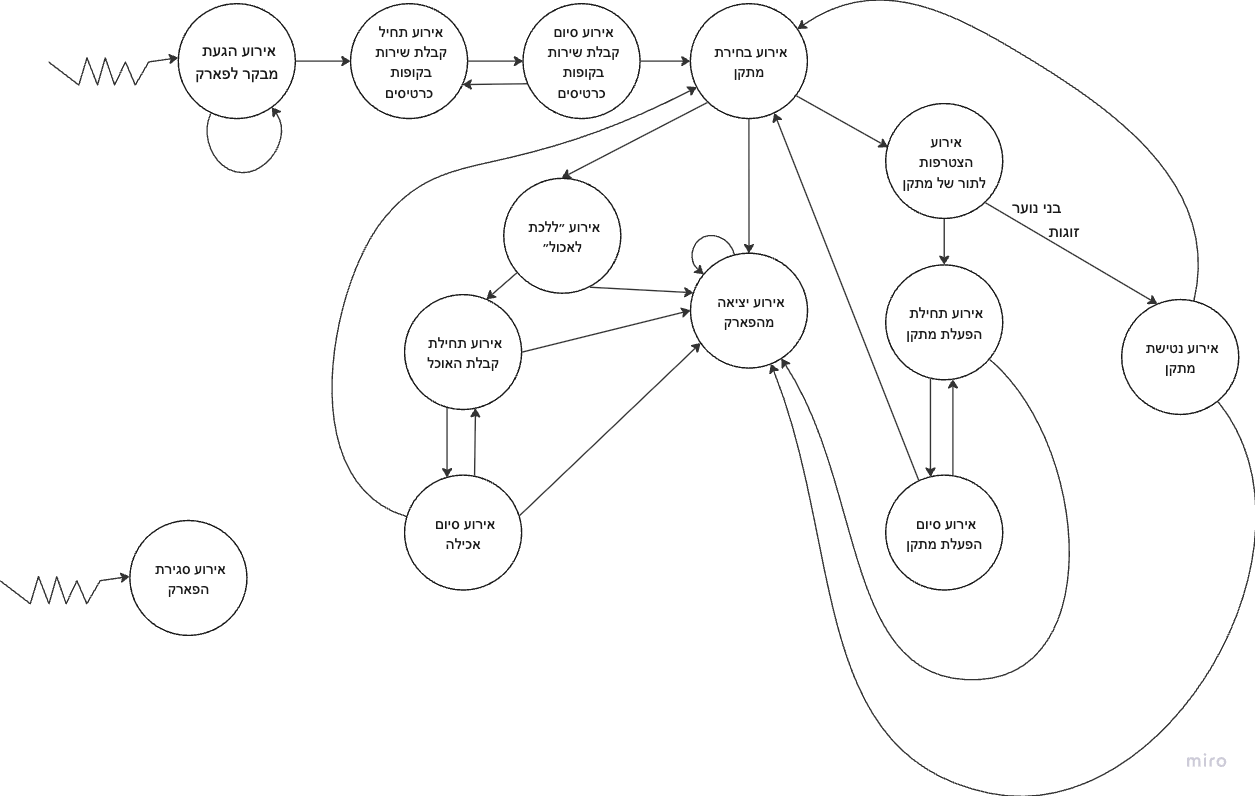

## Handling with events: Service at boxoffice
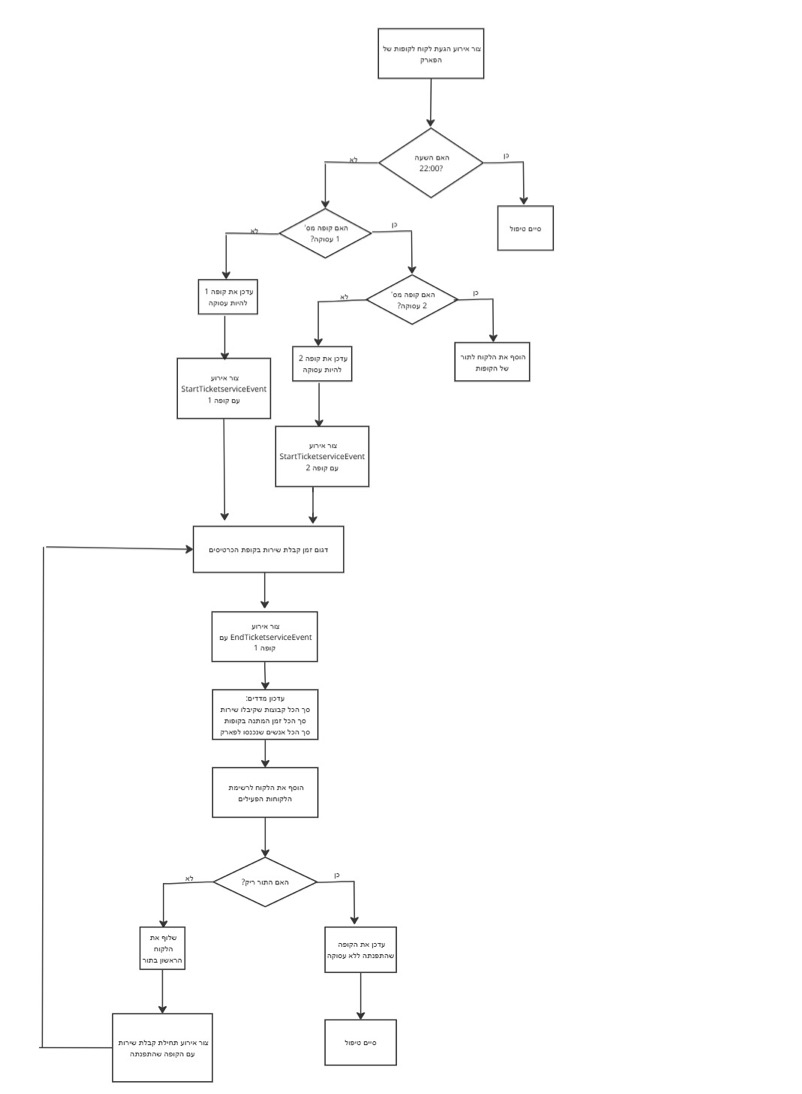

## Handling with events: Service at food stall
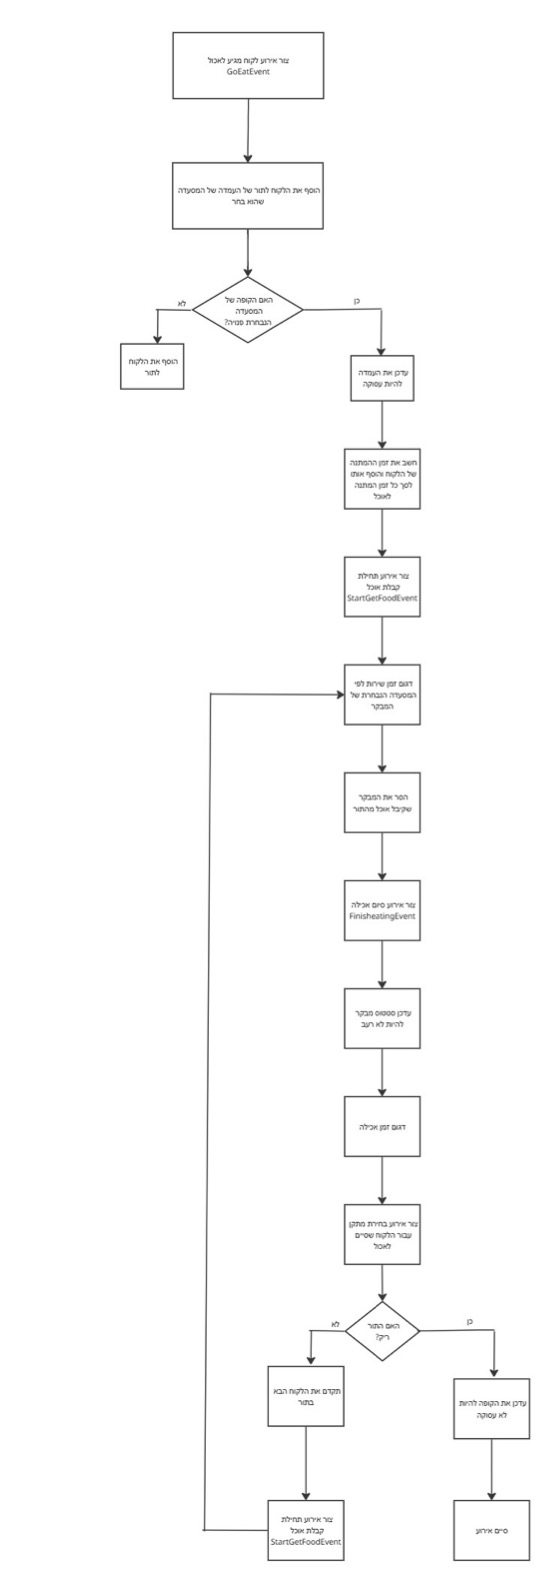

## Handling with events: Choosing and taking a ride/choosing if should eat or not
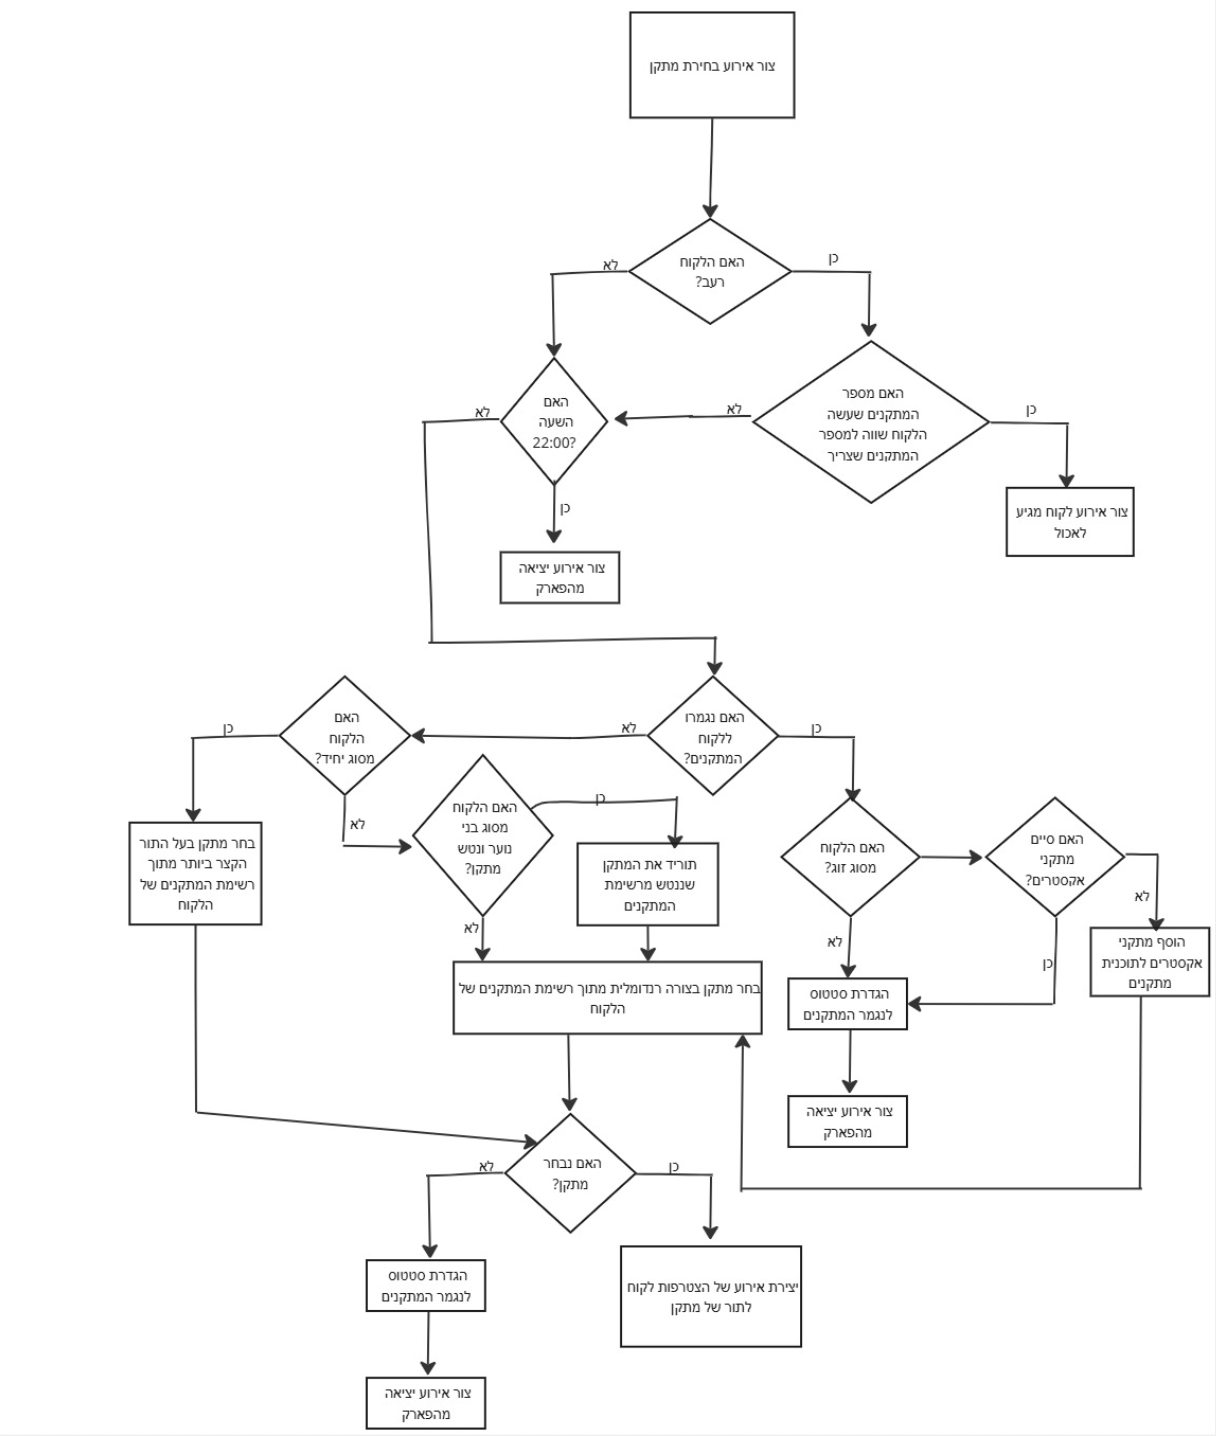

## Arriving to the park event
<div dir="rtl">
הגעת מבקר לפארק: אם אין קופות פנויות, המבקר נכנכס לתור, אחרת עובר לאירוע קניית כרטיס בקופה הרלוונטית. מייצרים את הלקוח מאותו הסוג הבא שיגיע לאירוע זה בהתאם לאלגוריתמי הדגימה.

In [ ]:
class VisitorArrivalEvent(Event):
    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor
        self.visitor.arrival_time=self.time
    def handle(self, simulation):
        simulation.simulation_time = self.time
        self.visitor.arrival_time=self.time
        #  send visitor hone if the park is closed
        if self.time > 1320:      # 22:00
            return

        # get to the box office or get in the queue
        if not simulation.boxOffice1_busy:
            simulation.boxOffice1_busy = True
            simulation.schedule_event(
                StartTicketServiceEvent(self.time, self.visitor, box_office=1)
            )
        elif not simulation.boxOffice2_busy:
            simulation.boxOffice2_busy = True
            simulation.schedule_event(
                StartTicketServiceEvent(self.time, self.visitor, box_office=2)
            )
        else:
            simulation.arrival_queue.append(self.visitor)
            simulation.queue_length_log.append((self.time, len(simulation.arrival_queue)))

        simulation.log_queue_length()

        # sampling the next visitor arrival time
        ARRIVAL_END   = {'family':960, 'single':1260, 'couple':1200, 'teenagers':1080}
        ARRIVAL_FUNC  = {
            'family'   : simulation.sim_utils.sample_family_arrival,
            'single'   : simulation.sim_utils.sample_single_arrival,
            'couple'   : simulation.sim_utils.sample_couple_arrival,
            'teenagers': simulation.sim_utils.sample_teenagers_arrival
        }

        v_type     = self.visitor.visitor_type
        next_time  = self.time + ARRIVAL_FUNC[v_type]()
        if next_time < ARRIVAL_END[v_type]:           # עדיין בתוך חלון ההגעה
            next_visitor = simulation.create_visitor(v_type, next_time)
            simulation.schedule_event(
                VisitorArrivalEvent(next_time, next_visitor)
            )

## Start getting service at the box office event

<div dir="rtl">
תחילת קניית כרטיס. מציאת משך הזמן של מכירת הכרטיס. במידה וזה מתאפשר מבחינת סיום יום ניצור את אירוע סיום קניית כרטיס בהתאם לזמן בו התבצעה הרכישה.


In [ ]:
class StartTicketServiceEvent(Event):
    def __init__(self, time, visitor, box_office):
        super().__init__(time)
        self.visitor = visitor
        self.box_office = box_office

    def handle(self, simulation):
        simulation.simulation_time = self.time
        alternative= simulation.alternative
        service_time = simulation.sim_utils.sample_ticket_service_time(alternative)
        if self.time + service_time >1319:
            simulation.arrival_queue.append(self.visitor)
        else:
            simulation.schedule_event( EndTicketServiceEvent(self.time + service_time, self.visitor, self.box_office) )


## Finish getting service at the box office event
<div dir="rtl">
סיום רכישת כרטיסים. המבקר הבא בתור ישובץ לקופה הבאה במידה והתור עדיין ריק. אחרת, הקוםה מתפנה. המבקר שסיים נשלח לאירוע בחירת מתכן. עדכון משתנים סטטיסטיים הקשורים לשירות וכמויות מבקרים בקופות הכרטיסים.

In [ ]:
class EndTicketServiceEvent(Event):
    def __init__(self, time, visitor, box_office):
        super().__init__(time)
        self.visitor     = visitor
        self.box_office  = box_office

    def handle(self, simulation):
        simulation.simulation_time = self.time
        simulation.total_served_groups += 1
        wait_time=self.time - self.visitor.arrival_time
        simulation.waiting_times_at_boxoffice.append(wait_time)
        simulation.total_wait_time_boxoffice +=  wait_time
        simulation.amount_of_groups_entered_the_park += 1
        simulation.amount_of_visitors_entered_the_park += self.visitor.group_size
        simulation.active_visitors.append(self.visitor)

        # send visitor to choose first ride
        self.visitor.status= "end day"
        simulation.schedule_event( ChooseRideEvent(self.time, self.visitor))
        # give service to the next visitor in queue
        if simulation.arrival_queue:
            next_v = simulation.arrival_queue.pop(0)
            simulation.queue_length_log.append((self.time, len(simulation.arrival_queue)))
            simulation.schedule_event(
                StartTicketServiceEvent(self.time, next_v, self.box_office)
            )
        else:
            # queue is empty --> box office is not busy anymore
            if self.box_office == 1:
                simulation.boxOffice1_busy = False
            else:
                simulation.boxOffice2_busy = False

        simulation.log_queue_length()


## Choosing a ride event
<div dir="rtl">
בחירת מתקן. במידה ויש ללקוח מתקנים אותם הוא עדיין יכול לבצע, וטרם מתקיימים התנאים שצריך בשביל שהלקוח ילך לאכול, הלקוח יבחר מתקן בהתאם לשיטה שלו לפי סוג המבקר (רנדומלית/לפי התור הקצר ביותר). ובמידה והגיע הזמן של המבקר לאכול מבחינת התנאים, מעבירים את הלקוח לאירוע תחילת אכילה.

In [ ]:
class ChooseRideEvent(Event): #choose ride / go to eat
    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor

    def handle(self, simulation):
        simulation.simulation_time = self.time
        # check if visitor is hungry
        if self.visitor.restaurant_choice == "hotdog":
          chosen_food_stall = simulation.foodStalls[0]
        elif self.visitor.restaurant_choice == "falafel":
          chosen_food_stall = simulation.foodStalls[1]
        elif self.visitor.restaurant_choice == "chinese":
          chosen_food_stall = simulation.foodStalls[2]
        if self.visitor.hungry and self.visitor.rides_completed == self.visitor.eating_policy:
          simulation.schedule_event(GoEatEvent(self.time, self.visitor, chosen_food_stall))

        if self.time>= 1320:
               simulation.schedule_event(ExitParkEvent(self.time, self.visitor))


        ride_options = self.visitor.ride_plan
        if self.visitor.visitor_type == "couple" and not ride_options and not self.visitor.finished_extreme:
            simulation.RideManager.get_initial_extreme_plan_for_visitor(self.visitor)
            self.visitor.finished_extreme = True

        if not ride_options:
            self.visitor.status = "no more ride"
            simulation.schedule_event(ExitParkEvent(self.time, self.visitor))
            return

        # choosing according to visitor type
        if self.visitor.visitor_type == "single" and self.visitor.ride_plan:
           chosen_ride = simulation.RideManager.get_shortest_queue_ride(self.visitor)


        #special case: only of teenagers abandon ride
        elif (self.visitor.visitor_type == "teenagers" and
            self.visitor.last_abandoned_ride is not None):
            filtered_rides = [r for r in ride_options if r != self.visitor.last_abandoned_ride] # מסננים החוצה את המתקן שננטש
            chosen_ride = simulation.RideManager.get_random_ride(filtered_rides)

        elif self.visitor.visitor_type == "family" or self.visitor.visitor_type == "couple" or (self.visitor.visitor_type == "teenagers" and self.visitor.last_abandoned_ride is None):
            chosen_ride = simulation.RideManager.get_random_ride(ride_options)

        if chosen_ride:
            simulation.schedule_event(JoinRideQueueEvent(self.time, self.visitor, chosen_ride))
        else:
            self.visitor.status = "no more ride"
            simulation.schedule_event(ExitParkEvent(self.time, self.visitor))


## Joining a ride's queue event
<div dir="rtl">
הצטרפות לתור של מתקן. במידה והמתקן פנוי והמבקר הוא הראשון בתור הוא יעבור לאירוע תחילת מתקן. אחרת, מצטרף לתור של המתקן. בנוסף נוצר אירוע נטישה במקרה של זוג או בני נוער.

In [ ]:
class JoinRideQueueEvent(Event):
    def __init__(self, time, visitor, ride):
        super().__init__(time)
        self.visitor = visitor
        self.ride = ride

    def handle(self, simulation):
        simulation.simulation_time = self.time
        self.visitor.arrival_time=self.time
        if self.time>=1320:
           simulation.schedule_event(ExitParkEvent(self.time, self.visitor))

        # join to queue
        self.ride.queue.append(self.visitor)
        # if the queue is empty - start the ride
        if len(self.ride.queue) == 1:
            simulation.schedule_event(StartRideEvent(self.time, self.ride))

        # for couples and teenagers - add a future event of abandon
        if self.visitor.visitor_type in ["couple", "teenagers"]:
            abandon_time = self.time + self.visitor.max_wait_time
            simulation.schedule_event(
                AbandonRideEvent(abandon_time, self.visitor, self.ride)
            )

## Abandon a ride event
<div dir="rtl">
אירוע נטישת מתקן. מתבצע לאחר המתנה מקסימלית של בני נוער או זוג. במידה והלקוח הוא זוג, המתקן ימחק מרשימת המתקנים האופציונלים ויעבור למתקנים שננטשו וחזרה לבחירת מתקן. במידה והמבקר הוא מסוג בני נוער, תיווצר זמנית רשימה חדשה והיא זו שתישלח לאירוע בחירת מתקן. המתקן הננטש יחזור להיות אופצית בחירה לאחר עלייה למתקן נוסף אחד.

In [ ]:
class AbandonRideEvent(Event):
    def __init__(self, time, visitor, ride):
        super().__init__(time)
        self.visitor = visitor
        self.ride = ride
    def handle(self, simulation):
        simulation.simulation_time = self.time
        ride_name = self.ride.name

        if self.visitor not in self.ride.queue:
            return
        if self.time >= 1320:
           simulation.schedule_event(ExitParkEvent(self.time, self.visitor))
        simulation.total_abandoned_rides += 1
        self.ride.amount_of_times_abandoned += 1
        # if visitor is a couple - delete the ride ane add it to the abandoned rides list
        if self.visitor.visitor_type == "couple":
            simulation.RideManager.remove_ride_from_plan(self.visitor, ride_name)
            simulation.RideManager.add_abandoned_ride(self.visitor, ride_name)

        # if visitor is a teenager - update the last ride abandoned
        elif self.visitor.visitor_type == "teenagers":
            self.visitor.abandoned_once.add(ride_name)
            self.visitor.last_abandoned_ride = ride_name

        # choose the next ride
        simulation.schedule_event(ChooseRideEvent(self.time, self.visitor))

## Starting a ride event
<div dir="rtl">
תחילת פעילות מתקן. בחירת לקוחות מתוך התור לפי קיבולת המתקן והרכב הקבוצות "והעלתם למתקן״. לאחר מכן לקוחות שעלו למתקן מוסרים מהתור, המתקן יעבור למצב ״עסוק״ ומעבר לאירוע סיום מתקן.

In [ ]:

class StartRideEvent(Event):
    def __init__(self, time, ride):
        super().__init__(time)
        self.ride = ride

    def handle(self, simulation):
        simulation.simulation_time = self.time
        if self.ride.is_busy:
            return  # ride is already working, can not start right now
        queue = self.ride.queue
        capacity = self.ride.capacity
        batch = []
        total_size = 0
        total_groups_on_ride = 0

        # build a batch that fits the ride's capacity
        for visitor in queue:
            if total_size + visitor.group_size <= capacity:
                batch.append(visitor)
                total_size += visitor.group_size
                total_groups_on_ride += 1
                if self.time >= 1320:
                  simulation.schedule_event(ExitParkEvent(self.time, visitor))
            else:
                break


        # update number of groups on the ride
        self.ride.total_groups_riders += total_groups_on_ride
        self.ride.total_Visitors_riders += total_size
        self.ride.total_rounds_riders +=1
        self.ride.queue_length_log.append((self.time, len(queue)))


        # count waiting time for every group
        for visitor in batch:
          if self.time >= 1320:
              simulation.schedule_event(ExitParkEvent(self.time, visitor))
          wait_time = self.time - visitor.arrival_time
          self.ride.waiting_times.append((visitor.arrival_time, wait_time))
          self.ride.total_waiting_for_rides_time+= wait_time
          simulation.total_waiting_all_rides += wait_time
        # remove group from queue
        for visitor in batch:
            queue.remove(visitor)

        # start the ride
        self.ride.is_busy = True

        # calculate ride duration
        duration = self.ride.sample_duration()
        if   self.time + duration >= 1320: # send home if the park closes during or after ride starts
              self.ride.is_busy = False
              simulation.schedule_event(ExitParkEvent(self.time, visitor))
              for visitor in queue: # if park is closing, send people in queue home
                  simulation.schedule_event(ExitParkEvent(self.time, visitor))
        else: # add ending a ride event
             simulation.schedule_event(EndRideEvent(self.time + duration, self.ride, batch))


## Ending a ride event
<div dir="rtl">
 סיום סבב מתקן. עדכונים סטטיסטים ורשימת מתקנים אופציונלים של כל לקוח. במידה וישנם עוד מבקרים בתור למתקן יופעל אירוע תחילת פעילות מתקן. אחרת, המתקן כבר לא עסוק. המבקרים עוברים לאירוע בחירת מתקן מחדש.

In [ ]:

class EndRideEvent(Event):
    def __init__(self, time, ride, batch):
        super().__init__(time)
        self.ride = ride
        self.batch = batch

    def handle(self, simulation):
        simulation.simulation_time = self.time
        self.ride.is_busy = False
        for visitor in self.batch:
            # upate number of rides for a specific visitor
            visitor.rides_completed += 1
            simulation.sum_of_rides_completed_for_all_visitors += 1
            if self.ride.name in visitor.ride_plan:
               visitor.ride_plan.remove(self.ride.name)

            simulation.schedule_event(ChooseRideEvent(self.time, visitor))


           # update last abandined ride for teenagers only
            if visitor.visitor_type == "teenagers":
                visitor.last_abandoned_ride = None



                # start a new ride if there are people in the queue
        if self.ride.queue:
            simulation.schedule_event(StartRideEvent(self.time, self.ride))


## Leaving the park event
<div dir="rtl">
אירוע יציאה מהפארק. וידוא כי המבקר אכן לקוח פעיל, כלומר, המבקר טרם יצא מהפארק. מחיקתו מרשימת לקוחות פעילים ועדכונים נתונים סטטיסטים בהתאם לסטטוס עזיבה של המבקר.

In [ ]:
class ExitParkEvent(Event):
    def __init__(self, time, visitor):
        super().__init__(time)
        self.visitor = visitor

    def handle(self, simulation):
        if not self.visitor in simulation.active_visitors:
            return

        else:
                  # remove visitor from active visitors
               simulation.active_visitors.remove(self.visitor)
               simulation.simulation_time = self.time
               if self.visitor.status == "end day" :
                    simulation.left_because_of_time_limit += 1
               elif self.visitor.status == "no more ride":
                   simulation.left_because_of_no_more_rides += 1
        if simulation.active_visitors and self.time>=1320:
          for visitor in simulation.active_visitors:
            simulation.schedule_event(ExitParkEvent(self.time, visitor))

## Closing the park event
<div dir="rtl">
אירוע סגירת פארק. מעבר על המבקרים שעוד פעילים למרות שהפארק נסגר והעברתם לאירוע סיום. רלוונטי ללקוחות שממתינים בתור כלשהו בתוך הפארק.

In [ ]:
class ParkClosingEvent(Event):
    def __init__(self, time):
        super().__init__(time)

    def handle(self, simulation):
        for visitor in simulation.active_visitors:
            simulation.schedule_event(ExitParkEvent(self.time, visitor))

## Go eating event
<div dir="rtl">
הגעת מבקר לאכול: המבקר מצטרף לתור של דוכן המזון הרלוונטי. במידה והדוכן פנוי, המבקר הראשון בתור עובר לאירוע תחילת קבלת שירות מזון.

In [ ]:
class GoEatEvent(Event):
    def __init__(self, time, visitor, food_stall):
        super().__init__(time)
        self.visitor = visitor
        self.food_stall = food_stall

    def handle(self, simulation):
        simulation.simulation_time = self.time
        self.visitor.arrival_time = self.time
        self.food_stall.queue.append(self.visitor)

        # if food stall is available
        if not self.food_stall.is_busy:
          if self.time >=1320:
            simulation.schedule_event(ExitParkEvent(self.time, self.visitor))
          self.food_stall.is_busy = True
          wait_time = self.time - self.visitor.arrival_time
          simulation.waiting_times_at_food_stalls.append(wait_time)
          simulation.total_waiting_time_food_stalls += wait_time
          simulation.schedule_event(StartGetFoodEvent(self.time, self.visitor, self.food_stall))

## Start getting service at food stall event
<div dir="rtl">
קבלת אוכל. בהתאם לדוכן הנבחר נבחרת פונקציית דגימת זמן שירות המתאימה וזימון אירוע של סיום קבלת שירות בדוכן אוכל. עדכון משתנים סטטיסטים וקריאה לאירוע סיום אכילה.

In [ ]:
class StartGetFoodEvent(Event):
    def __init__(self, time, visitor, food_stall):
        super().__init__(time)
        self.visitor = visitor
        self.food_stall = food_stall

    def handle(self, simulation):
        simulation.simulation_time = self.time

        if self.visitor.restaurant_choice == "falafel":
            duration = self.visitor.sim.sample_falafel_service_time()
        elif self.visitor.restaurant_choice == "hotdog":
            duration = self.visitor.sim.sample_hotdog_service_time()
        else:
            duration = self.visitor.sim.sample_chinese_food_service_time()
        if duration +  self.time >= 1320:
           self.food_stall.is_busy = False
           simulation.schedule_event(ExitParkEvent(self.time, self.visitor))
        else:
              self.food_stall.queue.remove(self.visitor)
              simulation.amount_of_groups_eat += 1
              simulation.schedule_event(FinishEatingEvent(self.time + duration, self.food_stall, self.visitor))


## Finish Eating event
<div dir="rtl">
אירוע סיום אכילה. דוגמים זמן אכילה של לקמבקרוח מההתפלגות הרלוונטית, ואחר מכן מעבירים את המבקר לאירוע בחירת מתקן. במידה והתור עדיין לא ריק, הלקוח הבא בתור נשלח לאירוע תחילת קבל שירות בדוכן מזון. במידה ואין עוד מבקרים בתור, הדוכן מעודכן להיות פנוי.

In [ ]:
class FinishEatingEvent(Event):
    def __init__(self, time, food_stall, visitor):
        super().__init__(time)
        self.food_stall = food_stall
        self.visitor = visitor

    def handle(self, simulation):
        simulation.simulation_time = self.time
        self.visitor.hungry = False
        eating_time = self.visitor.sim.sample_eating_duration()
        if eating_time +  self.time >= 1320:
           simulation.schedule_event(ExitParkEvent(self.time, self.visitor))
        else:
        # schedule next action for the visitor
           simulation.schedule_event(ChooseRideEvent(self.time + eating_time, self.visitor))

        # check if there are more visitors in queue
        if self.food_stall.queue:
               next_visitor = self.food_stall.queue[0]
               self.food_stall.is_busy = True
               wait_time = simulation.simulation_time - next_visitor.arrival_time
               simulation.waiting_times_at_food_stalls.append(wait_time)
               simulation.total_waiting_time_food_stalls += wait_time
               simulation.schedule_event(StartGetFoodEvent(simulation.simulation_time, next_visitor, self.food_stall))
        else:
               self.food_stall.is_busy = False



# Luna Park Simulation Class
<div dir="rtl">

מחלקה זו מייצגת את הסימולציה עצמה. היא כוללת בתוכה את המופעים של כל הישויות בפארק ביום מסויים, יחד עם רשימות המאחסנות כל מיני מדדים שבדקנו. במחלקה זו מממושת פונקציית run שבעצם מריצה סימולציה של יום מסויים. יש לה זמן סיום ברור (הדקה ה-1320 המייצגת את השעה 22:00).
בנוסף, במחלקה זו נמצא ״שק האירועים״ ממנו שולפים כל פעם את האירוע הכי קרוב (מבחינת זמן) ומתמודדים עם האיורע (פונקצית handle).

In [ ]:
class LunaParkSimulation:
    def __init__(self, sim_utils, alternative):
        self.sim_utils = sim_utils
        self.simulation_time = 0
        self.event_queue = EventQueue()
        self.alternative = alternative
        self.boxOffice1_busy = False
        self.boxOffice2_busy = False
        self.arrival_queue = []

        self.total_Visitors_riders = 0
        self.waiting_times_at_boxoffice = []
        self.waiting_times_at_food_stalls = []
        self.amount_of_groups_eat =0
        self.total_wait_time_boxoffice = 0
        self.total_waiting_all_rides = 0
        self.total_waiting_time_food_stalls = 0
        self.total_served_groups = 0
        self.queue_length_log = []
        self.ride_queue_logs = defaultdict(list)
        self.active_visitors = []
        self.amount_of_groups_entered_the_park = 0
        self.amount_of_visitors_entered_the_park = 0
        self.total_abandoned_rides = 0
        self.sum_of_rides_completed_for_all_visitors = 0
        self.visitor_log = []
        self.current_state_statitics = []
        self.counter_not_enter = 0
        self.left_because_of_time_limit = 0
        self.left_because_of_no_more_rides = 0
        self.rides = self.initiate_rides()
        self.RideManager = RideManager(self.rides)
        self.foodStalls = self.initiate_food_stalls()

        self.exit_log = []
        self.CLOSING_TIME = 1320


    def schedule_event(self, event):
        if (event.time < 1320):
            self.event_queue.add_event(event)


    def create_visitor(self, v_type, time):
        ride_plan = self.RideManager.get_initial_ride_plan_for_visitor(v_type)
        visitor   = Visitor(v_type, time, self.sim_utils, ride_plan)
        return visitor


    def log_queue_length(self):
        self.queue_length_log.append((self.simulation_time, len(self.arrival_queue)))

    def log_ride_queues(self):
      for ride in self.rides:
        self.ride_queue_logs[ride.name].append((self.simulation_time, len(ride.queue)))

    def initiate_rides(self):
      if  self.alternative == 0:
            return [
                  Ride("big_rollercoaster", 24, "extreme", self.sim_utils.sample_big_rollercoaster_ride_time),
                  Ride("small_rollercoaster", 16, "both", self.sim_utils.sample_small_rollercoaster_ride_time),
                  Ride("ferris_wheel", 40, "family", self.sim_utils.sample_ferris_wheel_ride_time),
                  Ride("free_fall", 12, "extreme", self.sim_utils.sample_free_fall_ride_time),
                  Ride("tubing_river", 15, "family", self.sim_utils.sample_tubing_river_ride_time),
                  Ride("bumper_cars", 20, "family", self.sim_utils.sample_bumper_cars_ride_time),
                  Ride("boat_capsizes", 20, "extreme", self.sim_utils.sample_boat_capsizes_ride_time),

              ]
      elif self.alternative == 1:
              return [ # alternativ=2 adding to ferris whell capacity
                  Ride("big_rollercoaster", 24, "extreme", self.sim_utils.sample_big_rollercoaster_ride_time),
                  Ride("small_rollercoaster", 16, "both", self.sim_utils.sample_small_rollercoaster_ride_time),
                  Ride("ferris_wheel", 48, "family", self.sim_utils.sample_ferris_wheel_ride_time),
                  Ride("free_fall", 12, "extreme", self.sim_utils.sample_free_fall_ride_time),
                  Ride("tubing_river", 15, "family", self.sim_utils.sample_tubing_river_ride_time),
                  Ride("bumper_cars", 20, "family", self.sim_utils.sample_bumper_cars_ride_time),
                  Ride("boat_capsizes", 20, "extreme", self.sim_utils.sample_boat_capsizes_ride_time),

              ]
      else:
                return [   #  alternativ=3 adding to tubing river capacity
                  Ride("big_rollercoaster", 24, "extreme", self.sim_utils.sample_big_rollercoaster_ride_time),
                  Ride("small_rollercoaster", 16, "both", self.sim_utils.sample_small_rollercoaster_ride_time),
                  Ride("ferris_wheel", 40, "family", self.sim_utils.sample_ferris_wheel_ride_time),
                  Ride("free_fall", 12, "extreme", self.sim_utils.sample_free_fall_ride_time),
                  Ride("tubing_river", 24, "family", self.sim_utils.sample_tubing_river_ride_time),
                  Ride("bumper_cars", 20, "family", self.sim_utils.sample_bumper_cars_ride_time),
                  Ride("boat_capsizes", 20, "extreme", self.sim_utils.sample_boat_capsizes_ride_time),

              ]


    def initiate_food_stalls(self):
      return [
          FoodStall("hotdog", self.sim_utils.sample_hotdog_service_time),
          FoodStall("falafel", self.sim_utils.sample_falafel_service_time),
          FoodStall("chinese", self.sim_utils.sample_chinese_food_service_time)

      ]

    def run(self):
        CLOSING_TIME = 1319.9999999         # 22:00
        self.simulation_time = 600   # 10:00

        arrival_end = {
            'family'    : 960,   # 16:00
            'single'    : 1260,  # 21:00
            'couple'    : 1200,  # 20:00
            'teenagers' : 1080   # 18:00
        }

        first_family     = 600 + self.sim_utils.sample_family_arrival()
        first_single     = 600 + self.sim_utils.sample_single_arrival()
        first_couple     = 840 + self.sim_utils.sample_couple_arrival()
        first_teenagers  = 720 + self.sim_utils.sample_teenagers_arrival()

        self.schedule_event(VisitorArrivalEvent(first_family,    self.create_visitor('family',    first_family)))
        self.schedule_event(VisitorArrivalEvent(first_single,    self.create_visitor('single',    first_single)))
        self.schedule_event(VisitorArrivalEvent(first_couple,    self.create_visitor('couple',    first_couple)))
        self.schedule_event(VisitorArrivalEvent(first_teenagers, self.create_visitor('teenagers', first_teenagers)))

        self.schedule_event(ParkClosingEvent(CLOSING_TIME))

        # simulation loop
        while not self.event_queue.is_empty():
            event = self.event_queue.pop_next_event()
            self.simulation_time = event.time
            self.log_queue_length()
            self.log_ride_queues()
            event.handle(self)

        self.current_state_statitics.append(self.total_wait_time_boxoffice)
        self.current_state_statitics.append(self.total_waiting_time_food_stalls)
        self.current_state_statitics.append(self.amount_of_groups_eat)
        for ride in self.rides:
          self.current_state_statitics.append(ride.total_waiting_for_rides_time)
          self.current_state_statitics.append(ride.total_rounds_riders)
          self.current_state_statitics.append(ride.total_Visitors_riders)
          self.current_state_statitics.append(ride.total_groups_riders)
          self.current_state_statitics.append(ride.amount_of_times_abandoned)

        self.current_state_statitics.append(self.total_abandoned_rides)
        self.current_state_statitics.append(self.sum_of_rides_completed_for_all_visitors)
        self.current_state_statitics.append(self.amount_of_groups_entered_the_park)
        self.current_state_statitics.append(self.amount_of_visitors_entered_the_park)
        self.current_state_statitics.append(self.left_because_of_time_limit)
        self.current_state_statitics.append(self.left_because_of_no_more_rides)
        self.current_state_statitics.append(len(self.arrival_queue))


# Current State Simulating and Analysis

Ride Name,Average Waiting Time (minutes)
tubing_river,2.99
ferris_wheel,2.40
boat_capsizes,2.05
bumper_cars,1.93
big_rollercoaster,1.47
free_fall,1.41
small_rollercoaster,0.85


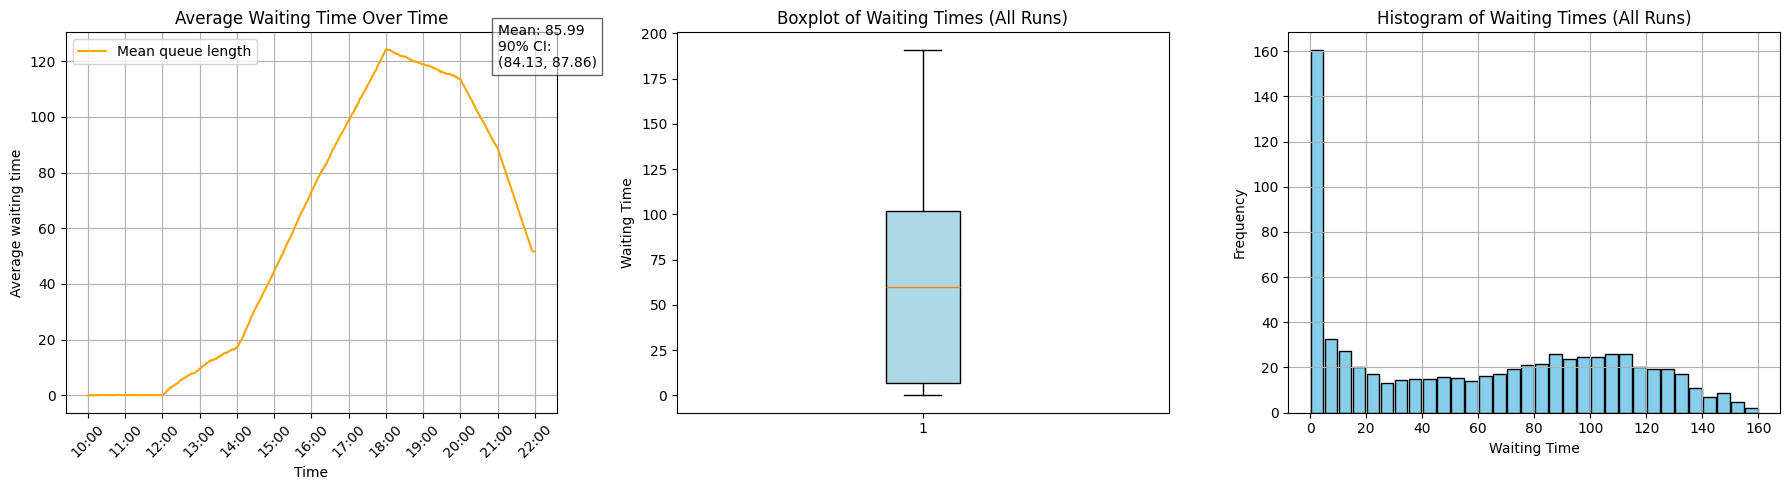

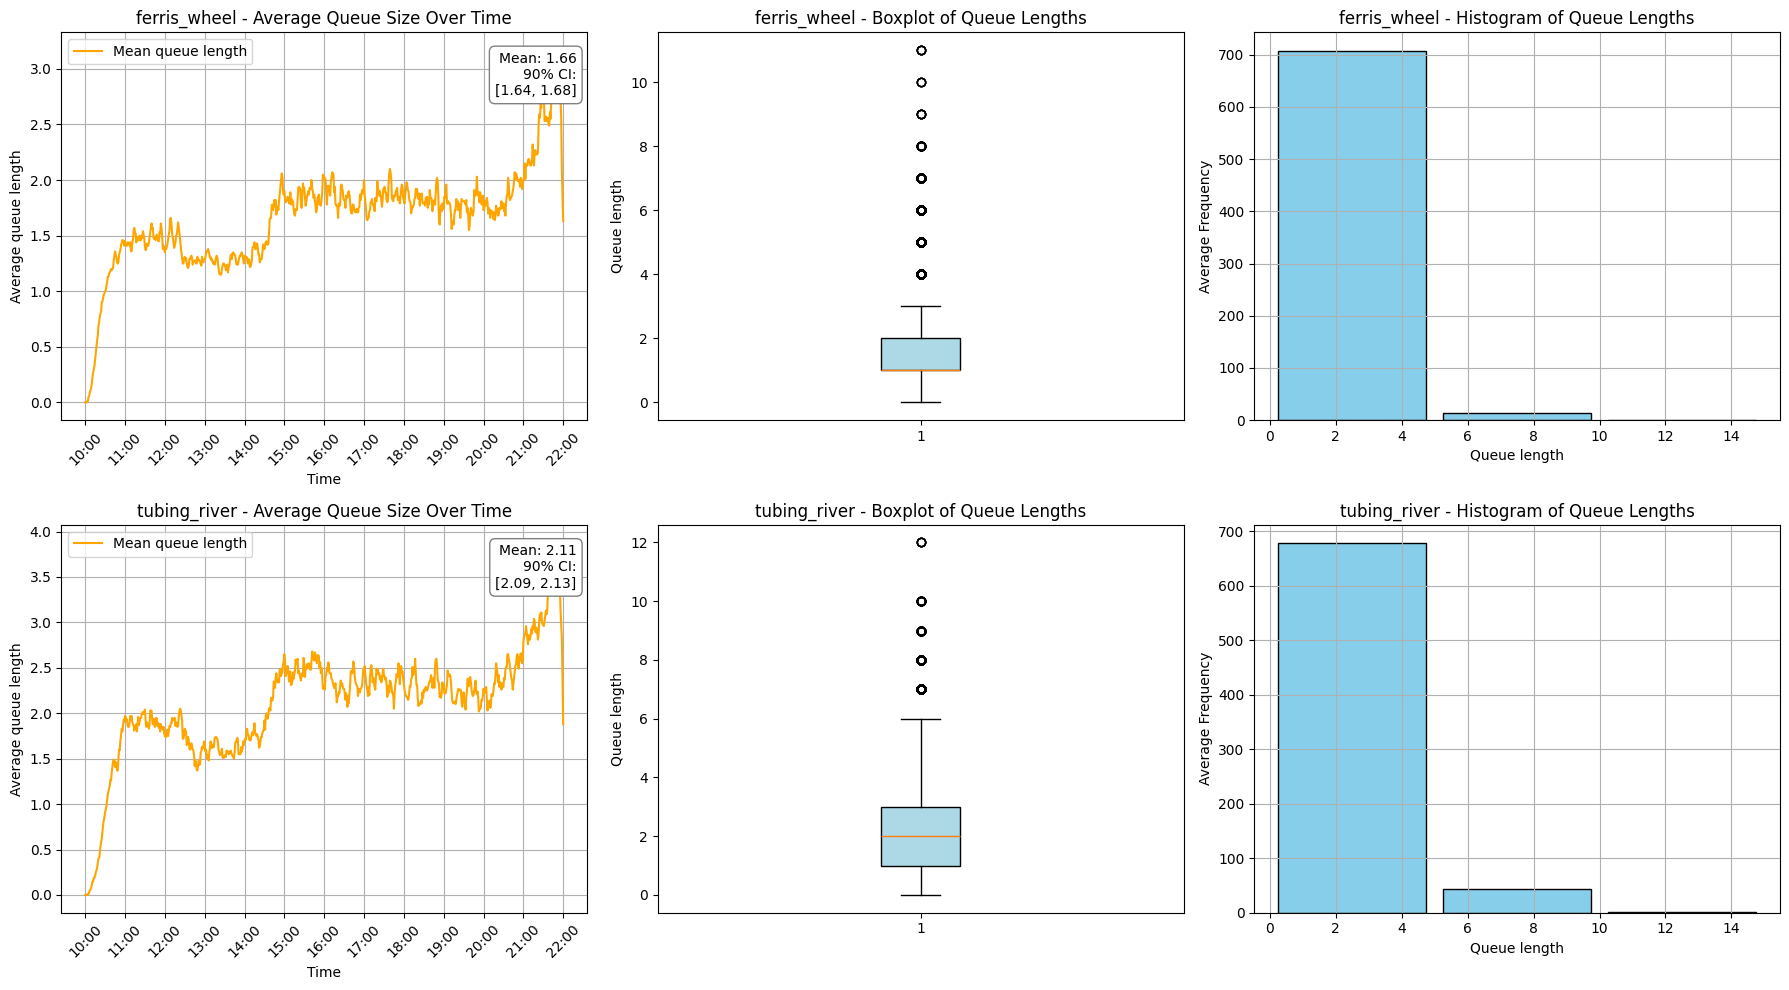

In [ ]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# settings
num_of_runs = 100
alternative_value = 0
confidence_level = 0.90
selected_rides = ["ferris_wheel", "tubing_river"]
time_range = list(range(600, 1321))

# variables for statistics
all_simulations = []
all_logs = []
mean_wait_times_per_run = []
lengths_of_queue = []
amounts_of_groups_entered_the_park = []
left_because_of_time_limit_log = []
left_because_of_no_more_rides_log = []
avg_waiting_times_per_ride = defaultdict(list)


# run 100 simulations
for i in range(num_of_runs):
    sim_utils = SimulationUtils()
    simulation = LunaParkSimulation(sim_utils, alternative=alternative_value)
    simulation.run()
    for ride in simulation.rides:
      if ride.total_groups_riders > 0:
          avg_wait = ride.total_waiting_for_rides_time / ride.total_groups_riders
          avg_waiting_times_per_ride[ride.name].append(avg_wait)
    all_simulations.append(simulation)
    all_logs.append(simulation.queue_length_log)
    lengths_of_queue.append(len(simulation.arrival_queue))
    wait_times = simulation.waiting_times_at_boxoffice
    mean_wait_times_per_run.append(np.mean(wait_times))
    amounts_of_groups_entered_the_park.append(simulation.amount_of_groups_entered_the_park)
    left_because_of_time_limit_log.append(simulation.left_because_of_time_limit)
    left_because_of_no_more_rides_log.append(simulation.left_because_of_no_more_rides)


# avg calculation
avg_queue_length = np.mean(lengths_of_queue)
avg_groups_entered = np.mean(amounts_of_groups_entered_the_park)
avg_left_time_limit = np.mean(left_because_of_time_limit_log)
avg_left_no_rides = np.mean(left_because_of_no_more_rides_log)

avg_waiting_times_sorted = sorted(
    [(ride_name, sum(times)/len(times)) if times else (ride_name, 0)
     for ride_name, times in avg_waiting_times_per_ride.items()],
    key=lambda x: x[1],
    reverse=True
)

html = f"""
<h2 style="font-family: Arial;">Simulation Summary</h2>
<div><strong>Average Length Of Queue In The Entrance:</strong> {avg_queue_length:.2f}</div>
<div><strong>Average Amount Of Groups Entered The Park:</strong> {avg_groups_entered:.2f}</div>
<div><strong>Average Amount Of Groups Left Because Of Time Limit:</strong> {avg_left_time_limit:.2f}</div>
<div><strong>Average Amount Of Groups Left Because Of No More Rides:</strong> {avg_left_no_rides:.2f}</div>

<h2 style="font-family: Arial; margin-top: 30px;">Average Queue Waiting Times Per Group (Sorted Descending)</h2>

<style>
    .styled-table {{
        border-collapse: collapse;
        margin: 20px 0;
        font-size: 16px;
        font-family: 'Segoe UI', sans-serif;
        min-width: 500px;
        border-radius: 8px 8px 0 0;
        overflow: hidden;
        box-shadow: 0 0 8px rgba(0, 0, 0, 0.15);
    }}
    .styled-table thead tr {{
        background-color: #4CAF50;
        color: #ffffff;
        text-align: center;
        font-weight: bold;
    }}
    .styled-table th, .styled-table td {{
        padding: 12px 15px;
        text-align: center;
    }}
    .styled-table tbody tr {{
        border-bottom: 1px solid #dddddd;
    }}
    .styled-table tbody tr:nth-of-type(even) {{
        background-color: #f3f3f3;
    }}
    .styled-table tbody tr:hover {{
        background-color: #e2f0d9;
    }}
</style>

<table class="styled-table">
    <thead>
        <tr>
            <th>Ride Name</th>
            <th>Average Waiting Time (minutes)</th>
        </tr>
    </thead>
    <tbody>
"""

for ride_name, avg_wait in avg_waiting_times_sorted:
    html += f"<tr><td>{ride_name}</td><td>{avg_wait:.2f}</td></tr>"

html += "</tbody></table>"

display(HTML(html))



# boxoffice queue analysis

queue_matrix = pd.DataFrame(index=time_range)
for run_index, log in enumerate(all_logs):
    df = pd.DataFrame(log, columns=["time", "queue_length"])
    df = df.sort_values("time").drop_duplicates(subset="time", keep="last")
    run_series = pd.Series(data=df["queue_length"].values, index=df["time"].values)
    run_series = run_series.reindex(time_range, method='ffill').fillna(0)
    queue_matrix[f"run_{run_index + 1}"] = run_series

queue_matrix["mean_queue_length"] = queue_matrix.mean(axis=1)
mean_queue_series = queue_matrix["mean_queue_length"]
all_queue_values = queue_matrix.drop(columns="mean_queue_length").values.flatten()

# CI
mean_box = np.mean(mean_wait_times_per_run)
std_dev_box = np.std(mean_wait_times_per_run, ddof=1)
n = len(mean_wait_times_per_run)
t_critical = stats.t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
margin_of_error = t_critical * (std_dev_box / np.sqrt(n))
ci_lower = mean_box - margin_of_error
ci_upper = mean_box + margin_of_error

bins = np.arange(0, 165, 5)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
histograms = []
for i in range(num_of_runs):
    values = queue_matrix[f"run_{i+1}"].values
    counts, _ = np.histogram(values, bins=bins)
    histograms.append(counts)
hist_array = np.array(histograms)
mean_counts = hist_array.mean(axis=0)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(time_range, mean_queue_series, label="Mean queue length", color='orange')
axs[0].set_title("Average Waiting Time Over Time")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Average waiting time")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xticks(range(600, 1321, 60))
axs[0].set_xticklabels([f"{h:02d}:00" for h in range(10, 23)], rotation=45)
axs[0].text(
    time_range[-1] - 60, max(mean_queue_series) * 0.95,
    f"Mean: {mean_box:.2f}\n90% CI:\n({ci_lower:.2f}, {ci_upper:.2f})",
    bbox=dict(facecolor='white', alpha=0.6),
    fontsize=10
)

axs[1].boxplot(all_queue_values, vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightblue'))
axs[1].set_title("Boxplot of Waiting Times (All Runs)")
axs[1].set_ylabel("Waiting Time")

axs[2].bar(bin_centers, mean_counts, width=4.5, edgecolor='black', color='skyblue')
axs[2].set_title("Histogram of Waiting Times (All Runs)")
axs[2].set_xlabel("Waiting Time")
axs[2].set_ylabel("Frequency")
axs[2].grid(True)

plt.tight_layout()
plt.show()

html_content = f"""
<h2 style="direction: rtl;">ניתוח זמן המתנה בקופות</h2>

<ul style="direction: rtl; font-size: 16px;">
  <li><b>היסטוגרמה:</b>
    <ul>
      <li>ההתפלגות מצביעה על כך שרוב זמני ההמתנה היו קצרים, אך קיימת גם פריסה רחבה של ערכים עד מעל 100 דקות.</li>
      <li>ריבוי תורים קצרים עשוי להעיד על קבוצות שוויתרו על מתקנים או שירות מהיר בשעות מסוימות.</li>
    </ul>
  </li>
  <li><b>Boxplot:</b>
    <ul>
      <li>תרשים הקופסה מראה פיזור רחב סביב הערך החציוני, מה שמעיד על שונות גבוהה בתורים לאורך היום.</li>
      <li>קיימים ערכים חריגים ארוכים, ייתכן בשעות שיא או בעקבות עומסים מצטברים.</li>
    </ul>
  </li>
  <li><b>נתוני הסיכום:</b>
    <ul>
      <li>ממוצע זמן ההמתנה לקבוצות בקופות: <b>{mean_box:.2f}</b> דקות</li>
      <li>רווח סמך ברמת ביטחון של 90%: <b>[{ci_lower:.2f}, {ci_upper:.2f}]</b></li>
    </ul>
  </li>
  <li><b>גורמים אפשריים להשפעה:</b>
    <ul>
      <li>בשעות הצהריים כל סוגי המבקרים מגיעים לפארק, מה שעשוי להסביר את העומס הקיצוני שמתחיל בשעה 14:00)</li>
      <li>זמני שירות ארוכים מידי בקופות הכרטיסים, מה שגורם להיווצרות של עומס קיצוני כאשר הרבה מהקרים מגיעים בשעות מסויימות</li>
      <li>ישנן מעט מידי קופות, יכול להיות שרק 2 קופות כרטיסיםפ מתקשות לעמוד בעומסים הכבדים שיש בשעות הצהריים, מה שגורם להמון מבקרים לעמוד בתורים</li>
    </ul>
  </li>
</ul>
"""

display(HTML(html_content))

# rides queue analysis

ride_queue_logs_all_runs = {ride_name: [] for ride_name in selected_rides}
for sim in all_simulations:
    for ride in sim.rides:
        if ride.name in selected_rides:
            ride_queue_logs_all_runs[ride.name].append(ride.queue_length_log)

ride_stats = {}
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, ride_name in enumerate(selected_rides):
    logs = ride_queue_logs_all_runs[ride_name]
    series_list = []

    for log in logs:
        df = pd.DataFrame(log, columns=["time", "queue_length"])
        df = df.sort_values("time").drop_duplicates("time", keep="last")
        series = pd.Series(df["queue_length"].values, index=df["time"].values)
        series = series.reindex(time_range, method='ffill').fillna(0).astype(float)
        series_list.append(series)

    matrix = pd.concat(series_list, axis=1)
    matrix.columns = [f"run_{j+1}" for j in range(len(series_list))]
    matrix["mean_queue_length"] = matrix.mean(axis=1)

    per_run_means = matrix.drop(columns="mean_queue_length").mean(axis=0).values
    mean = np.mean(per_run_means)
    std_dev = np.std(per_run_means, ddof=1)
    n = len(per_run_means)
    t_critical = stats.t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin_of_error = t_critical * (std_dev / np.sqrt(n))
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    ride_stats[ride_name] = {
        "mean": mean,
        "std_dev": std_dev,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
        "per_run_means": per_run_means
    }


    axs[i, 0].plot(matrix.index, matrix["mean_queue_length"], label="Mean queue length", color='orange')
    axs[i, 0].set_title(f"{ride_name} - Average Queue Size Over Time")
    axs[i, 0].set_xlabel("Time")
    axs[i, 0].set_ylabel("Average queue length")
    axs[i, 0].set_xticks(range(600, 1321, 60))
    axs[i, 0].set_xticklabels([f"{h:02d}:00" for h in range(10, 23)], rotation=45)
    axs[i, 0].grid(True)
    axs[i, 0].legend()
    axs[i, 0].text(
        0.98, 0.95,
        f"Mean: {mean:.2f}\n90% CI:\n[{ci_lower:.2f}, {ci_upper:.2f}]",
        transform=axs[i, 0].transAxes,
        fontsize=10,
        va="top", ha="right",
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4')
    )

    # Boxplot
    all_values = matrix.drop(columns="mean_queue_length").values.flatten()
    axs[i, 1].boxplot(all_values, vert=True, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
    axs[i, 1].set_title(f"{ride_name} - Boxplot of Queue Lengths")
    axs[i, 1].set_ylabel("Queue length")

    # Histogram
    bins = np.arange(0, np.max(all_values) + 5, 5)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    histograms = []
    for col in matrix.columns[:-1]:
        values = matrix[col].values
        counts, _ = np.histogram(values, bins=bins)
        histograms.append(counts)
    hist_array = np.array(histograms)
    mean_counts = hist_array.mean(axis=0)

    axs[i, 2].bar(bin_centers, mean_counts, width=4.5, edgecolor='black', color='skyblue')
    axs[i, 2].set_title(f"{ride_name} - Histogram of Queue Lengths")
    axs[i, 2].set_xlabel("Queue length")
    axs[i, 2].set_ylabel("Average Frequency")
    axs[i, 2].grid(True)

plt.tight_layout()
plt.show()
html_content = f"""
<h2 style="direction: rtl;">ניתוח עומס תורים למתקנים: גלגל ענק ואבובים</h2>

<ul style="direction: rtl; font-size: 16px;">
  <li><b>גרף קווי:</b>
    <ul>
      <li>הגרפים מציגים את ממוצע אורך התור בכל דקה במהלך היום – בין 10:00 ל־22:00.</li>
      <li>נראה כי בשני המתקנים יש עלייה הדרגתית בעומסים בשעות אחר הצהריים, עם תנודות בהתאם לשעות שיא.</li>
    </ul>
  </li>

  <li><b>Boxplot ו־Histogram:</b>
    <ul>
      <li>ב־<b>tubing_river</b> ניכרת שונות גבוהה יותר, עם תורים באורך 5–10 מבקרים לעיתים.</li>
      <li>ב־<b>ferris_wheel</b> מרבית התורים קצרים ויציבים, עם מעט חריגים.</li>
    </ul>
  </li>

  <li><b>נתוני סיכום (מבוסס על ממוצע בין ההרצות):</b>
    <ul>
      <li><b>tubing_river:</b> ממוצע אורך תור <b>{ride_stats['tubing_river']['mean']:.2f}</b> מבקרים |
        רווח סמך 90%: <b>[{ride_stats['tubing_river']['ci_lower']:.2f}, {ride_stats['tubing_river']['ci_upper']:.2f}]</b></li>
      <li><b>ferris_wheel:</b> ממוצע אורך תור <b>{ride_stats['ferris_wheel']['mean']:.2f}</b> מבקרים |
        רווח סמך 90%: <b>[{ride_stats['ferris_wheel']['ci_lower']:.2f}, {ride_stats['ferris_wheel']['ci_upper']:.2f}]</b></li>
    </ul>
  </li>

  <li><b>מסקנות:</b>
    <ul>
      <li><b>tubing_river</b> ככל הנראה מתמודד עם עומסים כבדים – יש לשקול הגדלה של קיבולת המתקן.</li>
      <li><b>ferris_wheel</b> מתפקד ביעילות יחסית – שומר על תורים סבירים לאורך כל שעות היום. הוספה של מקומות על המתקן, כלומר הגדלת הקיבולת עשוייה לקצר את התורים באופן משמעותי אף יותר, ולשפר את חווית הלקוח</li>
    </ul>
  </li>
</ul>
"""

display(HTML(html_content))



<div dir="rtl">

כעת נצטרך לחשב את מספר ההרצות הנדרש על מנת לעמוד בדיוק יחסי של 0.1 עבור חישוב המדדים לאחר הטמעת החלופות בסימולציה, על מנת לשפר את המדדים שהצגנו בניתוח המצב הקיים

In [ ]:

mean_tubing = np.mean(ride_stats["tubing_river"]["per_run_means"])
std_tubing = np.std(ride_stats["tubing_river"]["per_run_means"], ddof=1)

mean_ferris = np.mean(ride_stats["ferris_wheel"]["per_run_means"])
std_ferris = np.std(ride_stats["ferris_wheel"]["per_run_means"], ddof=1)

def check_required_n_relative(mean, std_dev, gamma, alpha_i, current_n, max_n=1000):
    rhs = gamma / (1 + gamma)
    n_required = None

    for n in range(2, max_n):
        t_crit = t.ppf(1 - alpha_i / 2, df=n - 1)
        lhs = (t_crit * std_dev / np.sqrt(n)) / mean

        if lhs <= rhs:
            n_required = n
            break

    if n_required is None:
        return {
            "status": "FAIL",
            "current_n": current_n,
            "n_required": None,
            "lhs": None,
            "rhs": rhs,
            "message": f"✗ Condition could not be satisfied even with {max_n} runs."
        }

    if current_n >= n_required:
        return {
            "status": "OK",
            "current_n": current_n,
            "n_required": n_required,
            "lhs": lhs,
            "rhs": rhs,
            "message": f"✓ You have {current_n} runs, and only {n_required} are required → Condition met."
        }
    else:
        return {
            "status": "NOT_OK",
            "current_n": current_n,
            "n_required": n_required,
            "lhs": lhs,
            "rhs": rhs,
            "message": f"✗ You have only {current_n} runs, but need at least {n_required} → Condition NOT met."
        }

# settings
gamma = 0.1
alpha_i = 0.1 / 3

results = []

for metric_name, mean, std in [
    ("Box Office", mean_box, std_dev_box),
    ("Tubing River", mean_tubing, std_tubing),
    ("Ferris Wheel", mean_ferris, std_ferris)
]:
    result = check_required_n_relative(mean, std, gamma, alpha_i, num_of_runs)
    result["metric"] = metric_name
    results.append(result)
for res in results:
    print(f"--- {res['metric']} ---")
    print(f"Status: {res['status']}")
    print(f"Required runs: {res['n_required']}")
    print(f"LHS: {res['lhs']:.5f} | RHS: {res['rhs']:.5f}")
    print(f"Message: {res['message']}\n")

--- Box Office ---
Status: OK
Required runs: 11
LHS: 0.08536 | RHS: 0.09091
Message: ✓ You have 100 runs, and only 11 are required → Condition met.

--- Tubing River ---
Status: OK
Required runs: 6
LHS: 0.07593 | RHS: 0.09091
Message: ✓ You have 100 runs, and only 6 are required → Condition met.

--- Ferris Wheel ---
Status: OK
Required runs: 5
LHS: 0.08111 | RHS: 0.09091
Message: ✓ You have 100 runs, and only 5 are required → Condition met.



# Alternetive Simulations and Analysis

<div dir="rtl">


כעת נצטרך להריץ מספיק סימולציות בהן הטמענו את כל אחת מהחלופות אותן רצינו לבדוק
על מנת לשפר את המדדים שנבדקו בחקר המצב הקיים, כאשר:


*   חלופה 0 מייצגת את המצב הקיים

*   חלופה 1 מייצגת את החלופה בה הטמענו את הקופות האוטומטיות בקופות הכרטיסים, והגדלת הקיבולת של מתקן הגלגל הענק


*   חלופה 2 מייצגת את החלופה בה הטמענו את הקופות האוטומטיות בקופות הכרטיסים, והגדלת הקיבולת של מתקן האבובים

בחרנו בחלופות אלו מפני שהתור בקופות הכרטיסים עמוס מאוד וזמני ההמתנה בו מאוד ארוכים, ולכן הבחירה בשיפור מדד זה הייתה טבעית. כתוצאה מכך האמנו כי הדבר יגרור כניסה של המון מבקרים נוספים, מה שיעמיס על התורים של המתקנים עד מאוד, ועשוי להגדיל את כמות הנטישות של מתקנים או כמות המבקרים שעוזבים את הפארק בגלל מגבלת הזמן. לפיכך, בחרנו להגדיל את הקיבלות של שני המתקנים העמוסים ביותר.

In [ ]:


num_of_runs = 20
alternative_values = [0, 1, 2]
selected_rides = ["ferris_wheel", "tubing_river"]

results = {}

for alt in alternative_values:
    all_simulations = []
    boxoffice_means = []
    mean_wait_times_per_run = []
    all_logs = []
    ride_means = {ride: [] for ride in selected_rides}

    for i in range(num_of_runs):
        sim_utils = SimulationUtils()
        simulation = LunaParkSimulation(sim_utils, alternative=alt)
        simulation.run()
        all_simulations.append(simulation)
        all_logs.append(simulation.queue_length_log)
        wait_times = simulation.waiting_times_at_boxoffice
        mean_wait_times_per_run.append(np.mean(wait_times))

        # queue in boxoffice
        boxoffice_means.append(np.mean(simulation.waiting_times_at_boxoffice))

        # queue in rides
        for ride in simulation.rides:
          if ride.name in selected_rides:
            df = pd.DataFrame(ride.queue_length_log, columns=["time", "queue_length"])
            df = df.sort_values("time").drop_duplicates("time", keep="last")
            series = pd.Series(df["queue_length"].values, index=df["time"].values)
            series = series.reindex(time_range, method='ffill').fillna(0)
            ride_means[ride.name].append(series.mean())  # Mean queue length over time

    # save results for every alternative
    results[alt] = {
        "boxoffice": boxoffice_means,
        "rides": ride_means
    }

print("Simulations completed.")

def compute_ci(data, confidence_level=0.95):
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    stderr = std / np.sqrt(n)
    t_crit = t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin = t_crit * stderr
    return mean, std, mean - margin, mean + margin

summary = []

for alt, data in results.items():
    mean, std, ci_low, ci_up = compute_ci(data["boxoffice"])
    summary.append({
        "Alternative": alt,
        "Metric": " זמן המתנה ממוצע בקופות",
        "Mean": mean,
        "Std Dev": std,
        "CI Lower": ci_low,
        "CI Upper": ci_up
    })
    for ride in ["ferris_wheel", "tubing_river"]:
        mean, std, ci_low, ci_up = compute_ci(data["rides"][ride])
        summary.append({
            "Alternative": alt,
            "Metric": f"אורך תור ממוצע ב{ 'גלגל ענק' if ride == 'ferris_wheel' else 'אבובים' }",
            "Mean": mean,
            "Std Dev": std,
            "CI Lower": ci_low,
            "CI Upper": ci_up
        })

df_summary = pd.DataFrame(summary)
from IPython.display import display
df_summary_rounded = df_summary.copy()
df_summary_rounded[["Mean", "Std Dev", "CI Lower", "CI Upper"]] = df_summary_rounded[
    ["Mean", "Std Dev", "CI Lower", "CI Upper"]
].round(3)
display(df_summary_rounded.sort_values(by=["Metric", "Alternative"]))





Simulations completed.


,Alternative,Metric,Mean,Std Dev,CI Lower,CI Upper
0,0,זמן המתנה ממוצע בקופות,80.217,11.217,74.968,85.467
3,1,זמן המתנה ממוצע בקופות,2.778,0.787,2.410,3.146
6,2,זמן המתנה ממוצע בקופות,2.535,0.427,2.335,2.735
2,0,אורך תור ממוצע באבובים,2.180,0.109,2.130,2.231
5,1,אורך תור ממוצע באבובים,2.673,0.124,2.615,2.731
8,2,אורך תור ממוצע באבובים,2.757,0.165,2.679,2.834
1,0,אורך תור ממוצע בגלגל ענק,1.687,0.079,1.651,1.724
4,1,אורך תור ממוצע בגלגל ענק,2.068,0.090,2.026,2.110
7,2,אורך תור ממוצע בגלגל ענק,2.124,0.127,2.065,2.184


# Comparison to Current State

In [ ]:
from scipy.stats import t
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def calculate_diff_ci(data1, data2, alpha=0.1, bonferroni_corrections=3):
    n1, n2 = len(data1), len(data2)
    mean1, mean2 = np.mean(data1), np.mean(data2)
    var1, var2 = np.var(data1, ddof=1), np.var(data2, ddof=1)

    mean_diff = mean2 - mean1
    se = np.sqrt((var1 / n1) + (var2 / n2))

    df_num = (var1 / n1 + var2 / n2) ** 2
    df_denom = ((var1**2) / ((n1**2) * (n1 - 1))) + ((var2**2) / ((n2**2) * (n2 - 1)))
    df = df_num / df_denom

    adjusted_alpha = alpha / bonferroni_corrections
    t_crit = t.ppf(1 - adjusted_alpha / 2, df)

    margin = t_crit * se
    ci_low = mean_diff - margin
    ci_up = mean_diff + margin

    return mean_diff, (ci_low, ci_up)

# ============================
# comparison to current state
# ============================
baseline = results[0]
metric_labels = {
    "boxoffice": "זמן המתנה ממוצע בקופות",
    "ferris_wheel": "אורך תור ממוצע בגלגל ענק",
    "tubing_river": "אורך תור ממוצע באבובים"
}

rows = []
for alt in [1, 2]:
    for metric_key in ["boxoffice", "ferris_wheel", "tubing_river"]:
        if metric_key == "boxoffice":
            base_data = baseline["boxoffice"]
            alt_data = results[alt]["boxoffice"]
        else:
            base_data = baseline["rides"][metric_key]
            alt_data = results[alt]["rides"][metric_key]

        mean_diff, (ci_low, ci_up) = calculate_diff_ci(base_data, alt_data)
        metric_label = metric_labels[metric_key]

        # recomendation
        if ci_up < 0:
            interp = "האלטרנטיבה עדיפה (קיצור תור מובהק)"
            why = "כאשר רווח הסמך שלילי, האלטרנטיבה נמוכה יותר מהמצב הקיים – כלומר עומס התור קטן יותר."
        elif ci_low > 0:
            interp = "המצב הקיים עדיף"
            why = "כאשר רווח הסמך חיובי, המצב הקיים נמוך יותר מהאלטרנטיבה – ולכן עדיף לשמור על המצב הנוכחי."
        else:
            interp = "אין הבדל מובהק"
            why = "רווח הסמך כולל את 0 ולכן לא ניתן להסיק איזו אלטרנטיבה עדיפה."

        rows.append({
            "מדד": metric_label,
            "השוואה": f"מצב קיים - אלטרנטיבה {alt}",
            "הפרש ממוצעים": f"{mean_diff:.4f}",
            "רווח סמך": f"({ci_low:.4f}, {ci_up:.4f})",
            "המלצה": interp,
            "מדוע?": why
        })

df = pd.DataFrame(rows)

def style_row(row):
    if "עדיפה" in row["המלצה"]:
        return ['background-color: #d0f0c0'] * len(row)
    elif "אין הבדל" in row["המלצה"]:
        return ['background-color: #fdf5c4'] * len(row)
    else:
        return ['background-color: #f9d5d3'] * len(row)

styled = df.style.apply(style_row, axis=1)\
    .set_table_attributes('style="font-size:14px; direction: rtl; border-collapse: collapse;"')\
    .set_caption("השוואת מדדים בין אלטרנטיבות למצב הקיים (90% רווח סמך)")\
    .set_properties(**{'text-align': 'center', 'border': '1px solid gray', 'padding': '5px'})

display(HTML(styled.to_html()))


,מדד,השוואה,הפרש ממוצעים,רווח סמך,המלצה,מדוע?
0,זמן המתנה ממוצע בקופות,מצב קיים - אלטרנטיבה 1,-77.4395,"(-83.2039, -71.6751)",האלטרנטיבה עדיפה (קיצור תור מובהק),"כאשר רווח הסמך שלילי, האלטרנטיבה נמוכה יותר מהמצב הקיים – כלומר עומס התור קטן יותר."
1,אורך תור ממוצע בגלגל ענק,מצב קיים - אלטרנטיבה 1,0.3807,"(0.3217, 0.4396)",המצב הקיים עדיף,"כאשר רווח הסמך חיובי, המצב הקיים נמוך יותר מהאלטרנטיבה – ולכן עדיף לשמור על המצב הנוכחי."
2,אורך תור ממוצע באבובים,מצב קיים - אלטרנטיבה 1,0.4925,"(0.4110, 0.5740)",המצב הקיים עדיף,"כאשר רווח הסמך חיובי, המצב הקיים נמוך יותר מהאלטרנטיבה – ולכן עדיף לשמור על המצב הנוכחי."
3,זמן המתנה ממוצע בקופות,מצב קיים - אלטרנטיבה 2,-77.6824,"(-83.4399, -71.9248)",האלטרנטיבה עדיפה (קיצור תור מובהק),"כאשר רווח הסמך שלילי, האלטרנטיבה נמוכה יותר מהמצב הקיים – כלומר עומס התור קטן יותר."
4,אורך תור ממוצע בגלגל ענק,מצב קיים - אלטרנטיבה 2,0.4367,"(0.3623, 0.5111)",המצב הקיים עדיף,"כאשר רווח הסמך חיובי, המצב הקיים נמוך יותר מהאלטרנטיבה – ולכן עדיף לשמור על המצב הנוכחי."
5,אורך תור ממוצע באבובים,מצב קיים - אלטרנטיבה 2,0.5763,"(0.4781, 0.6744)",המצב הקיים עדיף,"כאשר רווח הסמך חיובי, המצב הקיים נמוך יותר מהאלטרנטיבה – ולכן עדיף לשמור על המצב הנוכחי."


  <div style="direction:rtl" dir="rtl">

#  **מסקנות**

הניתוח מראה כי שתי החלופות שנבדקו (1 ו־2) כוללות שיפור מובהק במדד המרכזי – זמן המתנה ממוצע בתור בקופות – כתוצאה מהטמעת עמדות כרטוס אוטומטיות.
בשני המקרים נרשמה ירידה דרמטית וזמני המתנה קצרים משמעותית, באופן מובהק סטטיסטית (רווח סמך שלילי לחלוטין).

לגבי יתר המדדים:

חלופה 1, שכללה גם הגדלת קיבולת הגלגל הענק, לא הראתה שיפור מובהק במדד התור למתקן זה.

חלופה 2, שכללה גם הגדלת קיבולת האבובים, לא השיגה שיפור מובהק באורך התור למתקן האבובים.

היעדר השיפור בתורים למתקנים עשוי לנבוע מכך שהשיפור בעמדות הכרטוס הביא לכניסת יותר מבקרים לפארק - מה שמעלה את העומס על שאר המתקנים, ובכך "מנטרל" את ההשפעה החיובית של הגדלת הקיבולת.
כלומר, השיפור בכניסה יוצר אפקט משני על עומס כולל, שייתכן ויש לבחון בהסתכלות מערכתית רחבה יותר.

בכל מקרה, ניתן לקבוע כי השיפור המרכזי והמדיד נובע מהטמעת עמדות הכרטוס, שהביאה לירידה מובהקת במדדי העומס.
עלות הטמעת עמדות הכרטוס (40,000$) היא גם הנמוכה מבין החלופות, ולכן נחשבת ליעילה ביותר גם מבחינת יחס עלות–תועלת.

# **המלצות להמשך:**

1.   **יש** **ליישם** **את** **חלופת** **הכרטוס** **האוטומטי:**

זו חלופה מובהקת בשיפור המדדים.

תועלת גבוהה בעלות נמוכה יחסית.

תשפר משמעותית את חווית הלקוח בכניסה לפארק.
2.   **נכון** **לעכשיו** **אין** **הצדקה** **לביצוע** **השקעה** **בהגדלת** **קיבולת** **המתקנים:**


לא נמדד שיפור מובהק במדדי העומס על המתקנים.

ההשקעות אינן מוצדקות ביחס לתוצאה בפועל.

מומלץ להמשיך לנטר את זמני ההמתנה לגלגל הענק ולאבובים גם לאחר יישום הכרטוס האוטומטי - ולבחון מחדש בעתיד האם מתפתחת מגמת עומס שתצדיק השקעה במתקנים.

# Summary
  <div style="direction:rtl" dir="rtl">
העבודה מתארת תהליך סימולציה של לונה פארק ומבצעת ניתוח מעמיק של מדדים שונים במטרה לשפר את ביצועי הפארק ושפר את רווחת המבקרים.
 העבודה כוללת יצירת מודל סימולציה בו נבנו ישויות כמו מבקרים, מתקנים, דוכני אוכל, ומתקני הלונה פארק השונים, כאשר כל פעילות בפארק מתוארת כאירוע עם התפלגות זמן (כמו הגעת מבקר, רכישת כרטיסים, עלייה למתקן, ועוד).
  במהלך הסימולציה נבדקו מדדים כמו זמן המתנה ממוצע בתורים השונים כגון קופות הכרטיסים בכניסה, מתקנים ודוכני אוכל. השוואת חלופות שונות עבור שיפורים בשירותים (כגון קיצור זמן השירות בקופות הכרטיסים והגדלת קיבולת המתקנים) נעשתה כדי להבין את ההשפעה של שינויים בהתנהלות הפארק על המדדים השונים, וכתוצאה מכך על מדדי הפארק אותם בחנו. באמצעות ניתוח סטטיסטי וגרפים, הוצגו הצעות לשיפורים כמו הפיכת השירות בקופות לאוטומטי או הגדלת קיבולת של המתקנים העמוסים ביותר , תוך הבחנה בין חלופות והמלצה על הדרך האופטימלית לשיפור רווחת המבקרים בפארק וצמצום זמני ההמתנה. העבודה מספקת תובנות מעשיות כיצד לשפר את השירות הוחוויה בפארק התמקדות בשיפור המדדים הקריטיים לפארק.

